# Question 3: Investigating Topology in Node-Based Classification Using GNNs

In this section, we will explore the impact of graph topology on node-based classification using GNNs. The experiments will focus on analyzing different topological measures, visualizing their distributions, and evaluating GCN performance on 2 graphs with different topologies.

In [1]:
import json
import torch
import os
import random
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import networkx as nx
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from graph_ricci_curvature import GraphRicciCurvature

## Helper function and code for loading data

In [2]:
G1_TRAIN_FILE_NAME = "q3_G1_train.json"
G1_EVAL_FILE_NAME = "q3_G1_eval.json"

G1_TRAIN_DATA_PATH = os.path.join("data",G1_TRAIN_FILE_NAME)
G1_EVAL_DATA_PATH = os.path.join("data",G1_EVAL_FILE_NAME)

G2_TRAIN_FILE_NAME = "q3_G2_train.json"
G2_EVAL_FILE_NAME = "q3_G2_eval.json"

G2_TRAIN_DATA_PATH = os.path.join("data",G2_TRAIN_FILE_NAME)
G2_EVAL_DATA_PATH = os.path.join("data",G2_EVAL_FILE_NAME)

In [3]:
# Functions to load the data
def create_Adj_matrix(N, edge_index):
    """Creates the adjacency matrix"""
    A = torch.zeros((N, N), dtype=torch.float)
    for idx, jdx in edge_index:
        A[idx, jdx] = 1
        A[jdx, idx] = 1
    return A

def read_json_data(file_path, has_label=True):
    with open(file_path, 'r') as f:
        data = json.load(f)
    
    if not type(data) == list:
        item = data
        X = torch.tensor(item['features'], dtype=torch.float)
        N = len(X)
        A = create_Adj_matrix(N, item['edge_index'])
        if has_label:
            y = torch.tensor(item['label'], dtype=torch.long)
        else:
            y = None
        return (X,A,y)

    graph_data = []
    for item in data:
        X = torch.tensor(item['features'], dtype=torch.float)
        N = len(X)
        A = create_Adj_matrix(N, item['edge_index'])
        if has_label:
            y = torch.tensor(item['label'], dtype=torch.long)
        else:
            y = None
        
        graph_data.append((X,A,y))
    
    return graph_data


## Question 3.1 - Analyzing the Graphs


### Q3.1.b Visualizing and Comparing Topological and Geometric Measures of Two Graphs

Implement the following three functions to visualize and compare structural properties of two given graphs:

- `plot_node_degree_distribution_two_graphs`
- `plot_betweenness_centrality_distribution_two_graphs`
- `plot_ollivier_ricci_curvature_distribution_two_graphs`




In [4]:


def compute_node_degree(A):
    """
    Given an adjacency matrix A of shape (N, N),
    return the degree (row sum) for each of the N nodes.
    """
    degrees = A.sum(dim=1)  # sum across columns
    return degrees

# ####################################################
# MODIFY THE CODE BELOW 
# ####################################################  


def plot_node_degree_distribution_two_graphs(A1, A2):
    """
    Plots the node degree distributions of two graphs
    with adjacency matrices A1 and A2 (each of shape (N, N))
    in a single figure.
    
    """
    # Compute node degrees
    degrees_G1 = compute_node_degree(A1).numpy()
    degrees_G2 = compute_node_degree(A2).numpy()

    # Plot the distributions
    plt.figure(figsize=(12, 6))
    plt.hist(degrees_G1, bins=30, alpha=0.5, label='Graph 1')
    plt.hist(degrees_G2, bins=30, alpha=0.5, label='Graph 2')
    plt.xlabel('Node Degree')
    plt.ylabel('Frequency')
    plt.title('Node Degree Distribution')
    plt.legend()
    plt.show()

In [5]:
# ####################################################
# MODIFY THE CODE BELOW 
# ####################################################  

def plot_betweenness_distribution_two_graphs(A1, A2):
    """
    Plots the betweenness centrality distributions of two graphs
    defined by adjacency matrices A1 and A2 (each of shape (N, N)) 
    in a single figure.
    """
    # Convert PyTorch adjacency -> NumPy -> NetworkX Graph
    A1_np = A1.numpy()
    A2_np = A2.numpy()

    G1 = nx.from_numpy_array(A1_np)
    G2 = nx.from_numpy_array(A2_np)

    # Compute betweenness centrality for each graph
    betweenness_G1 = nx.betweenness_centrality(G1)
    betweenness_G2 = nx.betweenness_centrality(G2)

    # Extract betweenness centrality values
    betweenness_values_G1 = list(betweenness_G1.values())
    betweenness_values_G2 = list(betweenness_G2.values())

    # Plot the distributions
    plt.figure(figsize=(12, 6))
    plt.hist(betweenness_values_G1, bins=30, alpha=0.5, label='Graph 1')
    plt.hist(betweenness_values_G2, bins=30, alpha=0.5, label='Graph 2')
    plt.xlabel('Betweenness Centrality')
    plt.ylabel('Frequency')
    plt.title('Betweenness Centrality Distribution')
    plt.legend()
    plt.show()

In [6]:
# ####################################################
# MODIFY THE CODE BELOW 
# ####################################################  

def plot_ricci_curvature_distribution_two_graphs(A1, A2):
    """
    Plots the Ollivier-Ricci curvature distributions for two graphs
    defined by adjacency matrices A1 and A2 (PyTorch tensors).
    
    Parameters
    ----------
    A1, A2 : torch.Tensor
        Adjacency matrices for two undirected graphs (NxN).
    """
    # 1) Convert PyTorch adjacency -> NumPy -> NetworkX Graph
    A1_np = A1.numpy()
    A2_np = A2.numpy()

    G1 = nx.from_numpy_array(A1_np)
    G2 = nx.from_numpy_array(A2_np)

    # 2) Instantiate OllivierRicci object for each graph
    ricci_calculator_G1 = GraphRicciCurvature(G1)
    ricci_calculator_G2 = GraphRicciCurvature(G2)

    # 3) Compute the Ricci curvature
    curvatures1 = ricci_calculator_G1.compute_ricci_curvatures()
    curvatures2 = ricci_calculator_G2.compute_ricci_curvatures()

    # After computation, the Ricci curvature for each edge is stored in G[u][v]["ricciCurvature"]

    # 4) Gather edge-level Ricci curvature values
    ricci_values_G1 = []
    for (u, v), val in curvatures1.items():
        ricci_values_G1.append(val)

    ricci_values_G2 = []
    for (u, v), val in curvatures2.items():
        ricci_values_G2.append(val)

    # Continue with plotting ...

    # Plot the distributions
    plt.figure(figsize=(12, 6))
    plt.hist(ricci_values_G1, bins=20, alpha=0.5, label='Graph 1')
    plt.hist(ricci_values_G2, bins=20, alpha=0.5, label='Graph 2')
    plt.xlabel('Ollivier-Ricci Curvature')
    plt.ylabel('Frequency')
    plt.title('Ollivier-Ricci Curvature Distribution')
    plt.legend()
    plt.show()

In [7]:
G1_train = read_json_data(G1_TRAIN_DATA_PATH, has_label=True) #returns a list of (X,A,y) - features, Adj Matrix, per Graph label
G2_train = read_json_data(G2_TRAIN_DATA_PATH, has_label=True) #returns a list of (X,A,y) - features, Adj Matrix, per Graph label


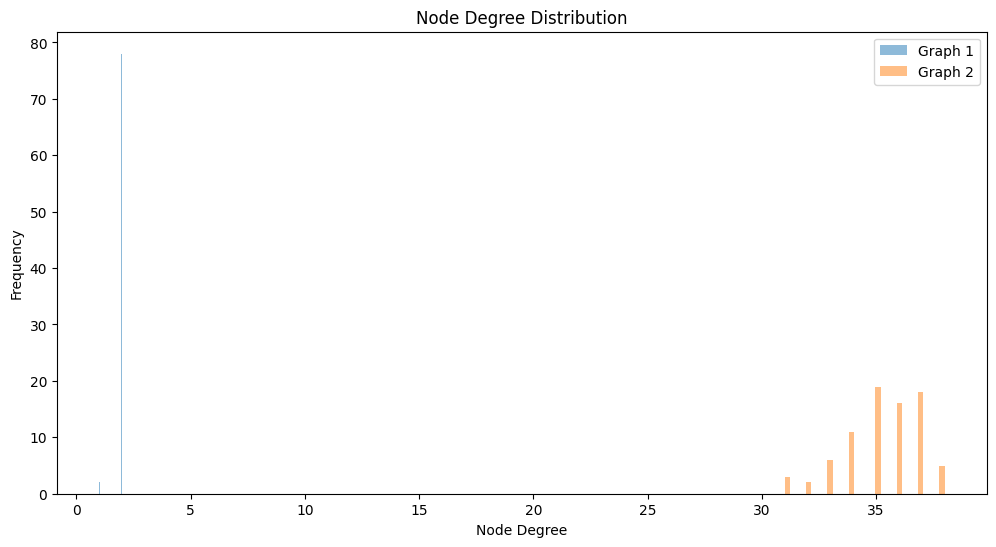

In [8]:
plot_node_degree_distribution_two_graphs(G1_train[1], G2_train[1])

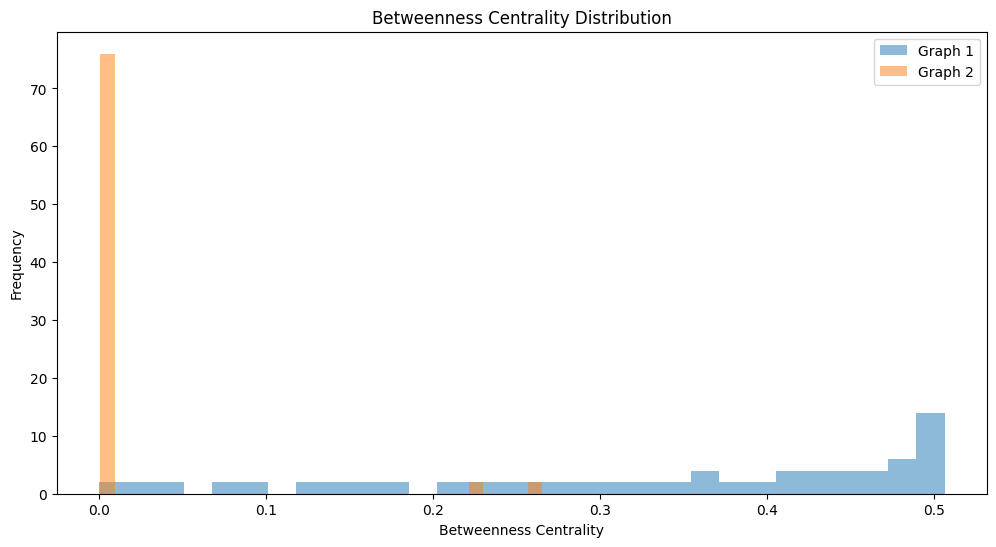

In [9]:
plot_betweenness_distribution_two_graphs(G1_train[1], G2_train[1])

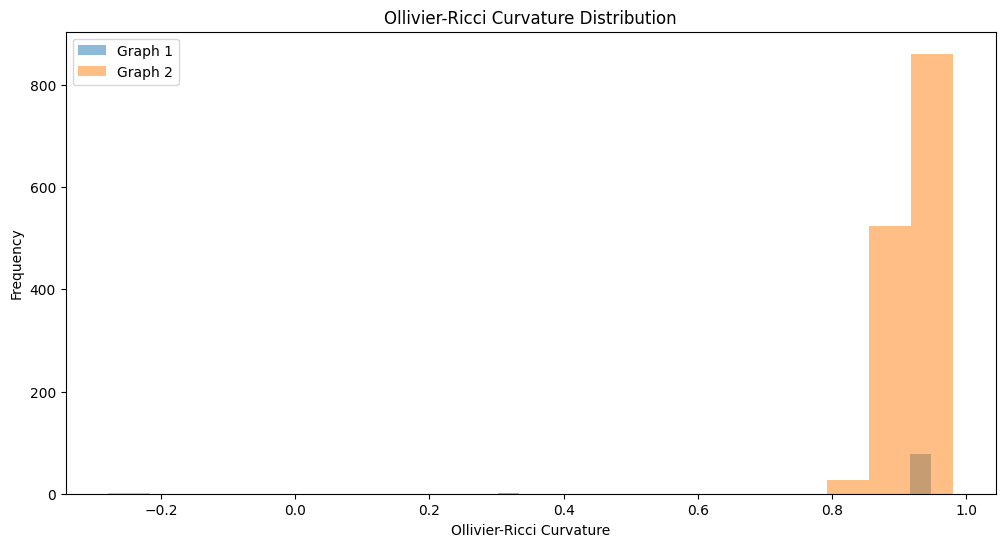

In [10]:
plot_ricci_curvature_distribution_two_graphs(G1_train[1], G2_train[1])

### Q3.1.c Visualizing the Graphs

Implement the `plot_graph` function to generate visual representations of both graphs. Ensure that the plots are clear and well-formatted.


In [11]:
def plot_graph(A):
    """
    Plots a graph defined by adjacency matrix A.
    Parameters
    ----------
    A : torch.Tensor
        Adjacency matrix of shape (N, N).
    """
    # Convert PyTorch adjacency matrix to NumPy array
    A_np = A.numpy()

    # Create a NetworkX graph from the adjacency matrix
    G = nx.from_numpy_array(A_np)

    # Draw the graph
    plt.figure(figsize=(8, 8))
    pos = nx.spring_layout(G)  # positions for all nodes
    nx.draw(G, pos, with_labels=True, node_color='skyblue', edge_color='gray', node_size=500, font_size=10)
    plt.title('Graph Visualization')
    plt.show()

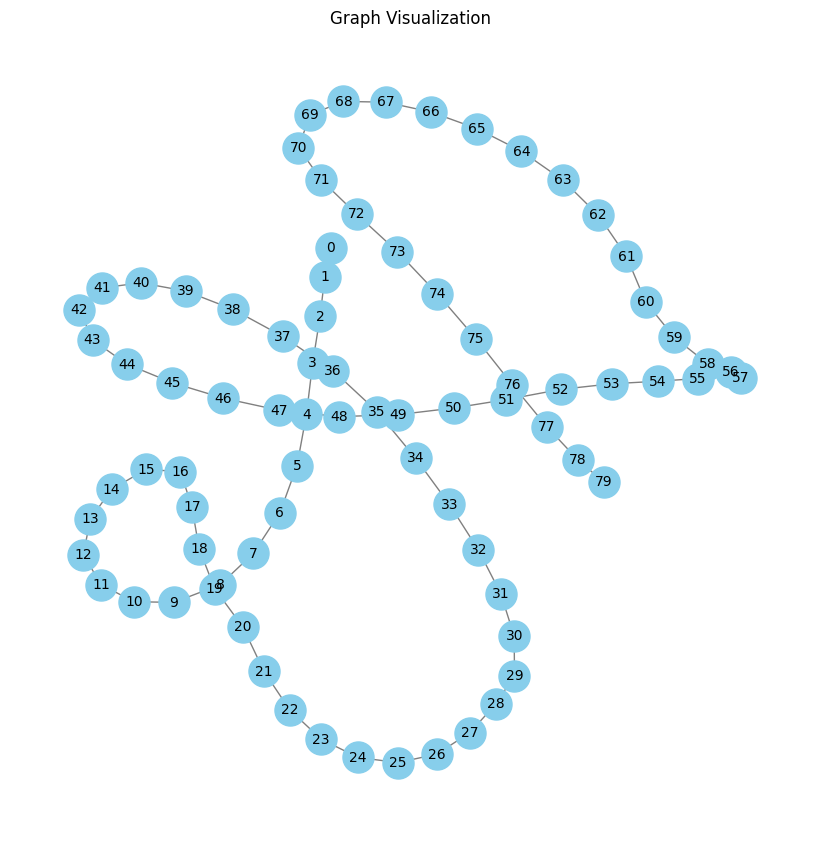

In [12]:
plot_graph(G1_train[1])

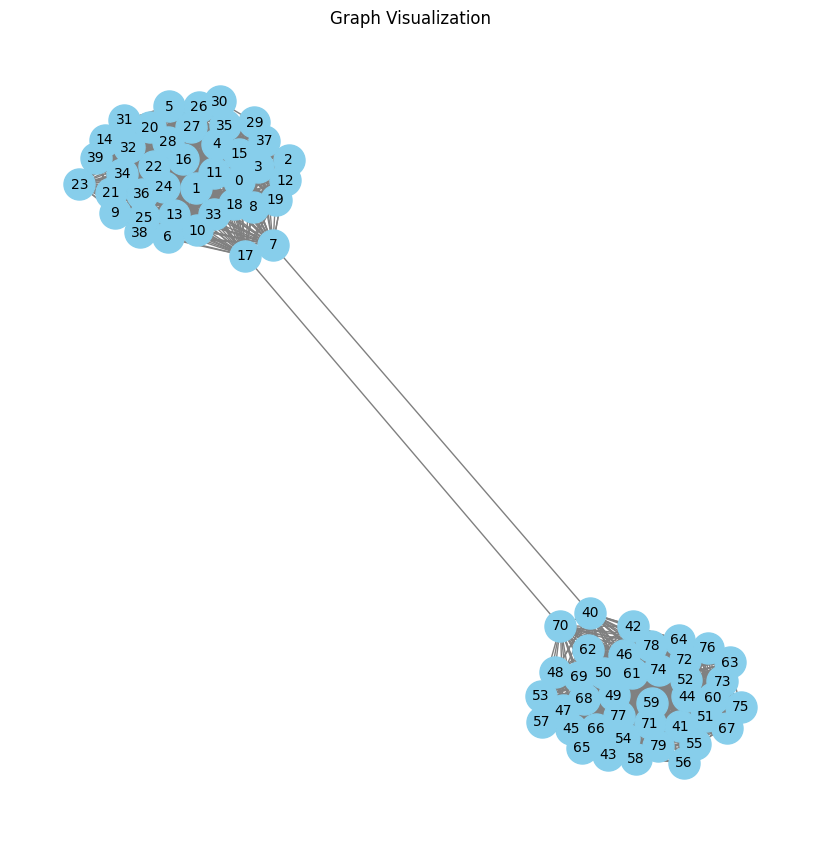

In [13]:
plot_graph(G2_train[1])

### Q3.1.d Visualizing Node Feature Distributions

- Implement the function `plot_node_feature_dist_by_class_two_graphs` to visualize the average node feature distribution per class for two given graphs.

- Do not consider the distribution of a specific feature $ x_i $, consider the mean of the feature vector $ \mathbf{x} $ for each node.

- The function should generate a plot similar to Figure 3 in the Coursework Desciription PDF.


In [14]:
def plot_node_feature_dist_by_class_two_graphs(Xa, ya, Xb, yb):
    """
    Plots the distribution of the average node features by class for two graphs.

    """

    Xa = Xa.cpu().numpy()
    Xb = Xb.cpu().numpy()
    ya = ya.cpu().numpy()
    yb = yb.cpu().numpy()

     # Calculate the average feature
    average_A = np.mean(Xa, axis=1)
    average_B = np.mean(Xb, axis=1)

    class_0_A = average_A[ya == 0]
    class_1_A = average_A[ya == 1]
    class_0_B = average_B[yb == 0]
    class_1_B = average_B[yb == 1]

    # Plot the distributions for graph A and B as overlapping bar graphs
    fig, axes = plt.subplots(1, 2, figsize=(10, 6))

    axes[0].hist(class_0_A, alpha=0.5, bins=25, label="Class 0", color="blue")
    axes[0].hist(class_1_A, alpha=0.5, bins=25, label="Class 1", color="orange")

    axes[1].hist(class_0_B, alpha=0.5, bins=25, label="Class 0", color="blue")
    axes[1].hist(class_1_B, alpha=0.5, bins=25, label="Class 1", color="orange")

    # Set Titles and Labels
    axes[0].set_title("Average Feature Distribution of Graph 1")
    axes[0].set_xlabel("Mean Feature Value")
    axes[0].set_ylabel("Count")
    axes[0].legend()

    axes[1].set_title("Average Feature Distribution of Graph 2")
    axes[1].set_xlabel("Mean Feature Value")
    axes[1].set_ylabel("Count")
    axes[1].legend()

    plt.tight_layout()
    plt.show()

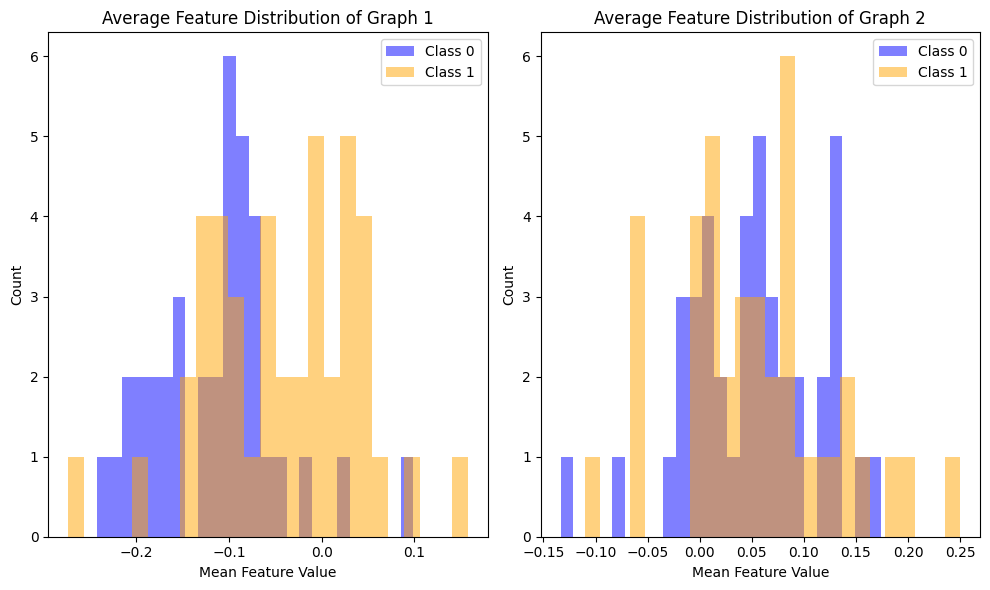

In [15]:
X1, A1, y1 = G1_train
X2, A2, y2 = G2_train
plot_node_feature_dist_by_class_two_graphs(X1, y1, X2, y2)

## Question 3.2 -  Evaluating GCN Performance on Different Graph Structures


### Helper functions for normalising the A matrix.

In [16]:
# Helper function to normalise the A matrix
def symmetric_normalize(A_tilde):
    """
    Performs symmetric normalization of A_tilde (Adj. matrix with self loops):
      A_norm = D^{-1/2} * A_tilde * D^{-1/2}
    Where D_{ii} = sum of row i in A_tilde.

    A_tilde (N, N): Adj. matrix with self loops
    Returns:
      A_norm : (N, N)
    """

    eps = 1e-5
    d = A_tilde.sum(dim=1) + eps
    D_inv = torch.diag(torch.pow(d, -0.5))
    return D_inv @ A_tilde @ D_inv


def patch_A_matrix(A):
    """Patches the A matrix"""
    A = A + torch.eye(A.size(0))
    A = symmetric_normalize(A)
    return A

def patch_A_for_dataset(dataset):
    """Patches the A matrix for a dataset (list)"""
    dataset = [ (X, patch_A_matrix(A), y) for X,A,y in dataset]
    return dataset

### Helper function for plotting training runs.

In [17]:
# Helper function for plotting:

def plot_training_and_validation(training_losses, validation_losses, aggregation="mean", graph1_label="Training Accuracy", graph2_label="Validation Accuracy", x_label="Epoch",title=None):
    """
    Plots the validation accuracy and training loss over epochs.
    Args:
        validation_losses: List of validation accuracies (or losses)
        training_losses: List of training accuracies (or losses)
        aggregation: Aggregation method used (default: "mean")
    """
    plt.figure(figsize=(10, 6))
    
    # Create figure with two y-axes
    fig, ax1 = plt.subplots(figsize=(10, 6))
    ax2 = ax1.twinx()
    
    # Plot training loss on the first y-axis
    epochs = range(1, len(training_losses) + 1)
    line1 = ax1.plot(epochs, training_losses, 'r-', label=f'{graph1_label}')
    ax1.set_xlabel(f"x_label")
    ax1.set_ylabel(f'{graph1_label}', color='r')
    ax1.tick_params(axis='y', labelcolor='r')
    
    # Plot validation accuracy on the second y-axis
    line2 = ax2.plot(epochs, validation_losses, 'b-', label=f'{graph2_label}')
    ax2.set_ylabel(f'{graph2_label}', color='b')
    ax2.tick_params(axis='y', labelcolor='b')
    
    # Add title and grid
    if not title:
        title = f'Training Accuracy and Validation Accuracy Over Time\nAggregation: {aggregation}'
    plt.title(title)

    ax1.grid(True)
    
    # Add legend
    lines = line1 + line2
    labels = [l.get_label() for l in lines]
    ax1.legend(lines, labels, loc='upper right')
    
    plt.tight_layout()
    plt.show()

### Provided GCN Code

In [18]:
#Provided GCN Implementation
class GCNLayer(nn.Module):
    """
    A single layer of a Graph Convolutional Network (GCN).
    """
    def __init__(self, input_dim, output_dim, use_nonlinearity=True):
        super(GCNLayer, self).__init__()
        self.use_nonlinearity = use_nonlinearity
        self.Omega = nn.Parameter(torch.randn(input_dim, output_dim) * torch.sqrt(torch.tensor(2.0) / (input_dim + output_dim)))
        self.beta = nn.Parameter(torch.zeros(output_dim))

    def forward(self, H_k, A_normalized):
        agg = torch.matmul(A_normalized, H_k) # local agg
        H_k_next = torch.matmul(agg, self.Omega) + self.beta
        return F.relu(H_k_next) if self.use_nonlinearity else H_k_next

class GraphNeuralNetwork(nn.Module):
    """
    A simple Graph Neural Network model using two layers of Graph Convolutional Network (GCN)
    for binary classification. The sigmoid activation is applied in the output layer only if
    use_nonlinearity is set to True.
    """
    def __init__(self, input_dim, hidden_dim):
        super(GraphNeuralNetwork, self).__init__()

        # Define GCN layers
        self.gcn1 = GCNLayer(input_dim, hidden_dim, True)
        self.gcn2 = GCNLayer(hidden_dim, 1, False)

    def forward(self, A, X, **kwargs):
        # Pass through GCN layers
        H1 = self.gcn1(X, A)
        H2 = self.gcn2(H1, A)  # Output shape: (num_nodes, 1)

        output = torch.sigmoid(H2)  # Sigmoid activation per node
        if torch.isnan(output).any():
            output = torch.where(torch.isnan(output), torch.zeros_like(output), output)

        if kwargs.get("return_embeddings", None):
            return output, (H1, H2)
        else:
            return output

### Helper functions for training GCN on a graph

In [19]:
import torch
import torch.optim as optim
import torch.nn as nn
from torch.nn.functional import binary_cross_entropy
from sklearn.metrics import accuracy_score, classification_report,precision_recall_fscore_support

def train_model(
    model,
    G_train,
    G_val,
    num_epochs=10,
    lr=0.0001,
    verbose=True,
    **kwargs,
):
    """
    Train the model, validate every 'validate_every' epochs, and pick the 
    checkpoint with best validation accuracy.

    Parameters:
    -----------
    model : torch.nn.Module
        The PyTorch model to train.
    G_train  = (X_train,A_train,y_train) : input
        the Graph 1
    Y_train = (X_val,A_val,y_val)
        the Graph 2
    num_epochs : int
        Number of training epochs.
    lr : float
        Learning rate for the optimizer.
    verbose: bool
        whether to display the loss, f1 and val_f1


    Returns:
    --------
    loss_history : list
        The training loss history across epochs.
    f1_train_history : list
        train F1s during training
    f1_val_history : list
        val F1s during training
    """
    X_train, A_train, y_train = G_train
    X_val, A_val, y_val = G_val

    model.train()
    optimizer = optim.AdamW(model.parameters(), lr=lr)
    loss_history = []
    train_f1_history = []
    validation_f1_history = []

    for epoch in range(num_epochs):
        # A single Epoch training.
        # TRAINING
        model.train()
        optimizer.zero_grad()
        if kwargs.get("return_embeddings", None):
            out, embeddings= model(A_train, X_train, **kwargs)
        else:
            out = model(A_train, X_train, **kwargs)
        out = out.squeeze(-1)  # shape: (N,) if needed
        y_float = y_train.float()  # for BCE

        # Compute training loss
        loss = binary_cross_entropy(out, y_float)
        loss.backward()

        # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        # Record training loss
        loss_value = loss.item()
        
        # EVALUATION
        loss_history.append(loss_value)
        train_prec, train_rec, train_f1, _ = evaluate_model(model, X_train, A_train, y_train)
        val_prec, val_rec, val_f1, _ = evaluate_model(model,  X_val, A_val, y_val)

        train_f1_history.append(train_f1)
        validation_f1_history.append(val_f1)                     
        # Evaluating the model
        if verbose:
            print(f"Epoch {epoch+1}, Training Loss: {loss_value}, Train F1: {train_f1:.4f}, Validation F1: {val_f1:.4f}")
            
    if kwargs.get("return_embeddings", None):
        return loss_history, train_f1_history, validation_f1_history, embeddings
    else:
        return loss_history, train_f1_history, validation_f1_history


@torch.no_grad()
def evaluate_model(model, X,A,y, **kwargs):
    """
    Runs forward pass, calculates binary predictions (threshold=0.5),
    and returns the accuracy score.
    """
    model.eval()
    if kwargs.get("return_embeddings", None):
        out,_ = model(A,X,**kwargs)  # shape: (N, 1)
    else:
        out = model(A,X,**kwargs)  # shape: (N, 1)
    out = out.squeeze(-1)  # shape: (N,)
    preds = (out >= 0.5).long()

    y_true = y.cpu().numpy()
    y_pred = preds.cpu().numpy()

    return precision_recall_fscore_support(y_true, y_pred, average="micro")


### Q3.2.a - Implementation of Layered GCN


• Implement a GCN where layers can be passed as input parameter and that can return all
embedding layers. (If you will not be able to do so, to get results implement one class per
layer).

• Train the GCN on G1 and G2 independently. Plot your results. (Note: you don’t need to
get a high performance at this stage, just make sure it trains).

In [20]:
# SOLUTION Q3.2.a
# ####################################################
# MODIFY THE CODE BELOW 
# ####################################################  
class LayeredGCN(nn.Module):
    """
    A simple Graph Neural Network model using two layers of Graph Convolutional Network (GCN)
    for binary classification. The sigmoid activation is applied in the output layer only if
    use_nonlinearity is set to True.
    """
    def __init__(self, input_dim, hidden_dim, num_layers=2, output_dim=2):
        super(LayeredGCN, self).__init__()
        self.num_layers = num_layers
        self.layers = nn.ModuleList()
        
        # Input layer
        self.layers.append(GCNLayer(input_dim, hidden_dim, True))
        
        # Hidden layers
        for _ in range(num_layers - 2):
            self.layers.append(GCNLayer(hidden_dim, hidden_dim, True))
        
        # Final layer
        self.layers.append(GCNLayer(hidden_dim, output_dim, True))

        self.output_layer = GCNLayer(output_dim, 1, False)

    def forward(self, A, X, **kwargs):

        # Forward pass through each layer
        graph_embedding = []
        H = X
        for layer in self.layers:
            H = layer(H, A)
            graph_embedding.append(H)

        H = self.output_layer(H, A)

        # Sigmoid activation
        graph_output = torch.sigmoid(H)

        if kwargs.get("return_embeddings", None):
            return graph_output, graph_embedding
        else:
            return graph_output

# ####################################################
# END OF MODIFICATION
# ####################################################  

### Code to run the training and evaluation of the model with different number of layers.

Adapt it as needed.

<Figure size 1000x600 with 0 Axes>

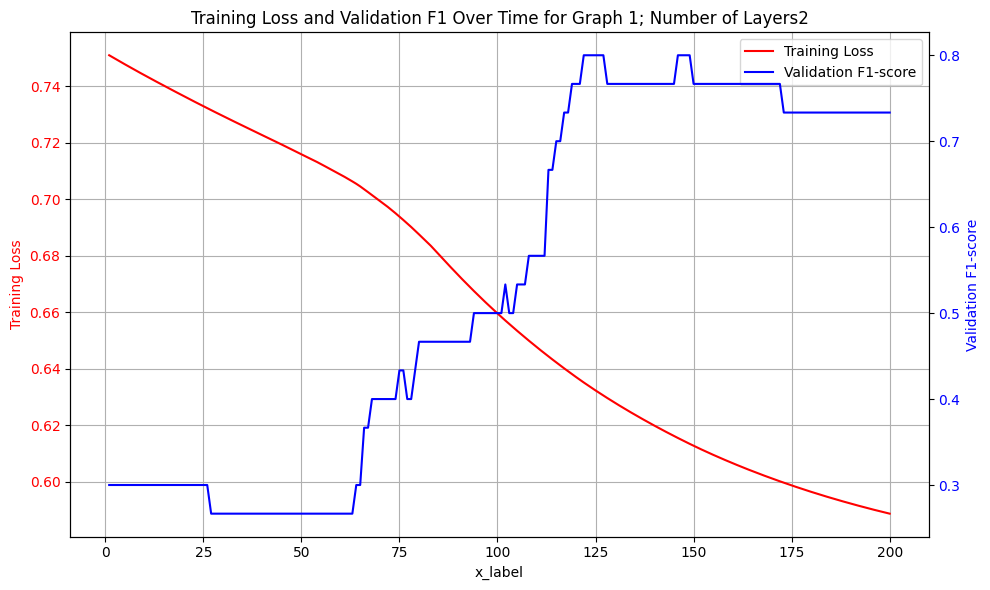

<Figure size 1000x600 with 0 Axes>

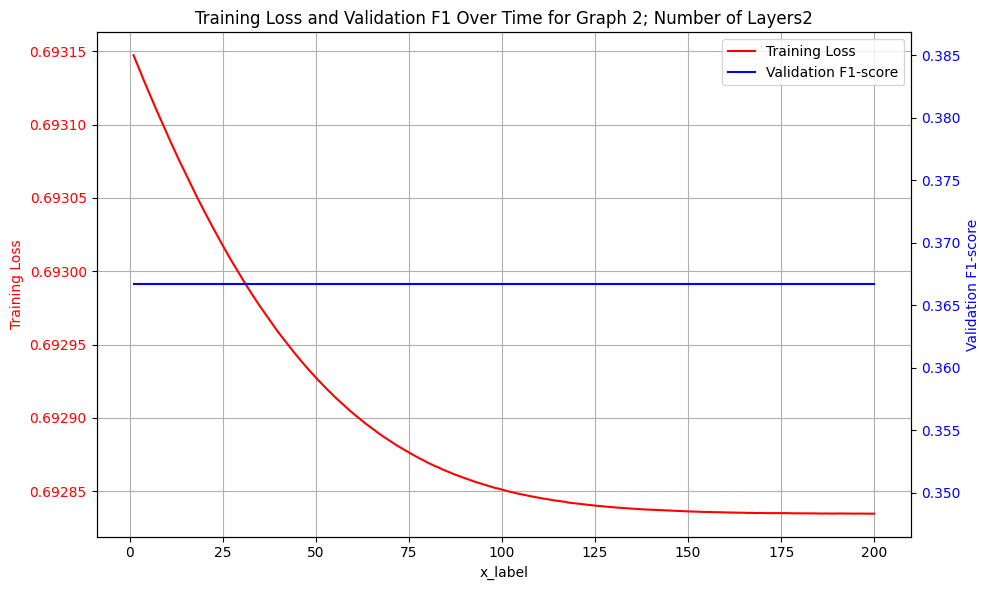

<Figure size 1000x600 with 0 Axes>

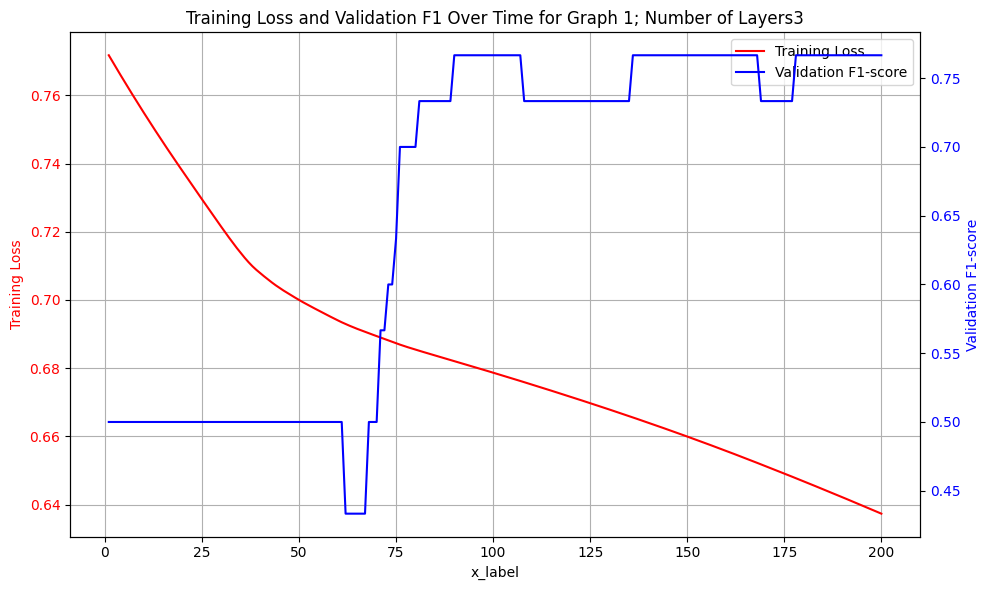

<Figure size 1000x600 with 0 Axes>

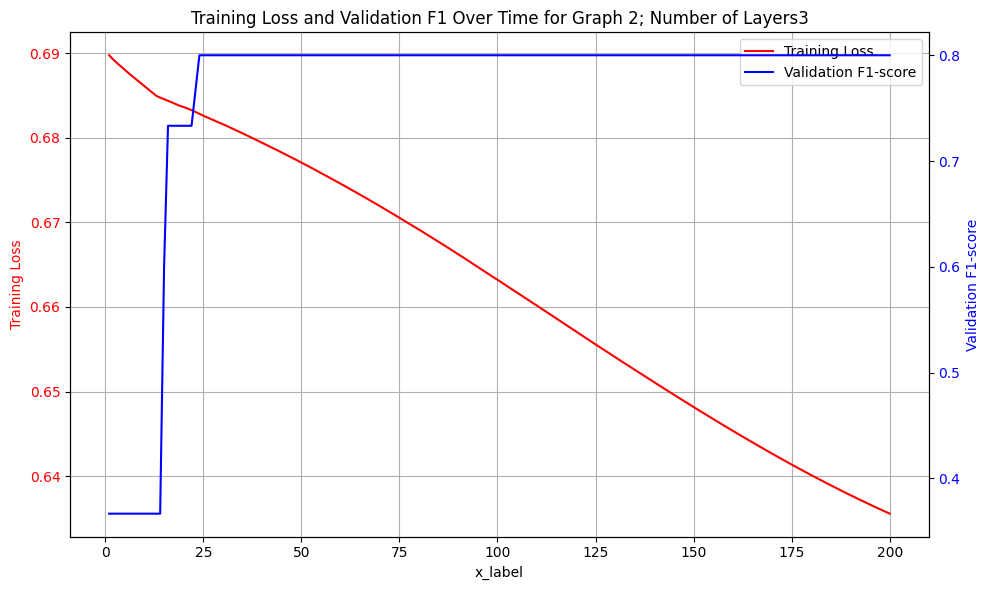

<Figure size 1000x600 with 0 Axes>

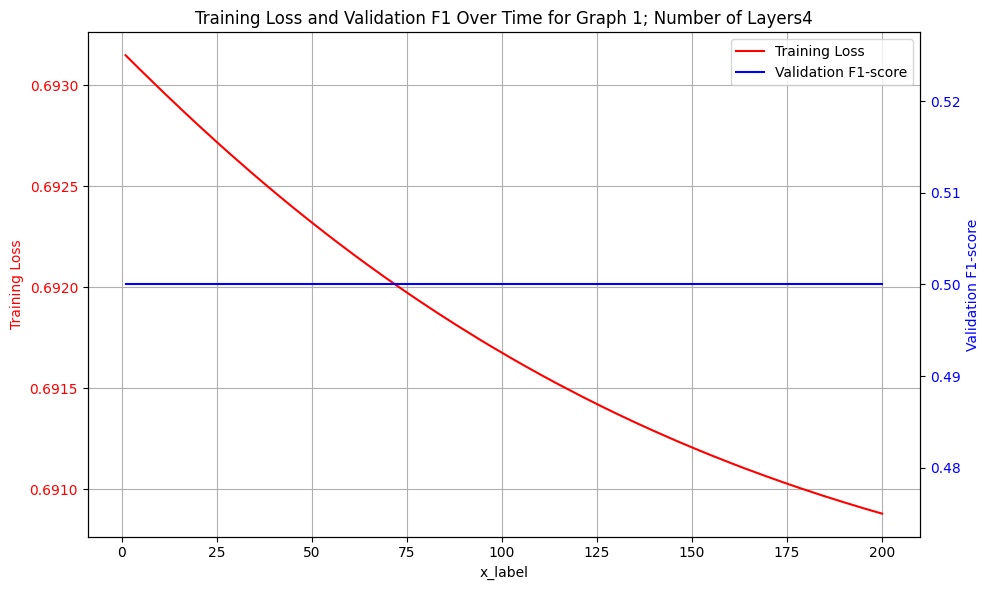

<Figure size 1000x600 with 0 Axes>

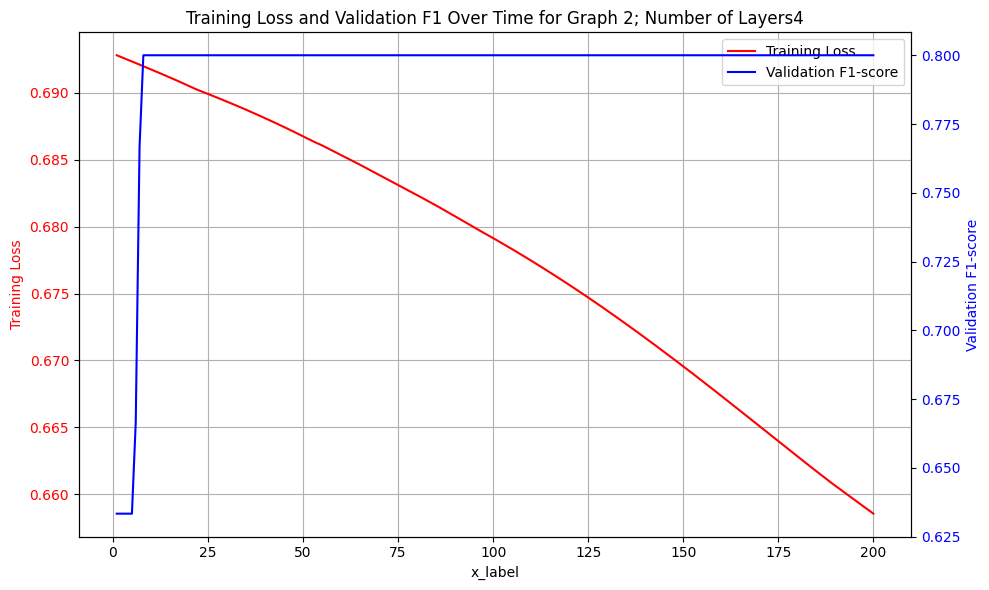

<Figure size 1000x600 with 0 Axes>

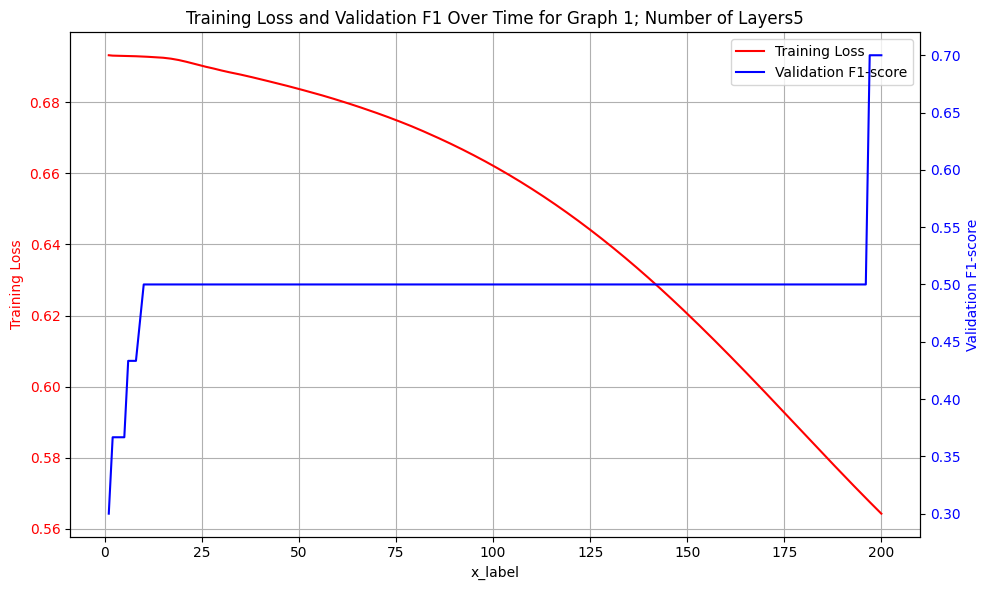

<Figure size 1000x600 with 0 Axes>

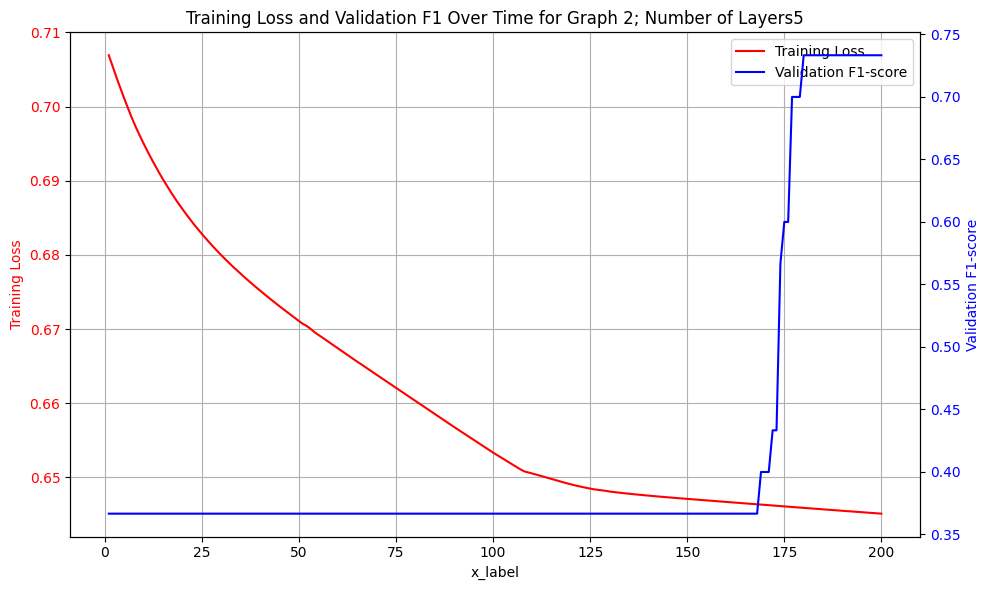

<Figure size 1000x600 with 0 Axes>

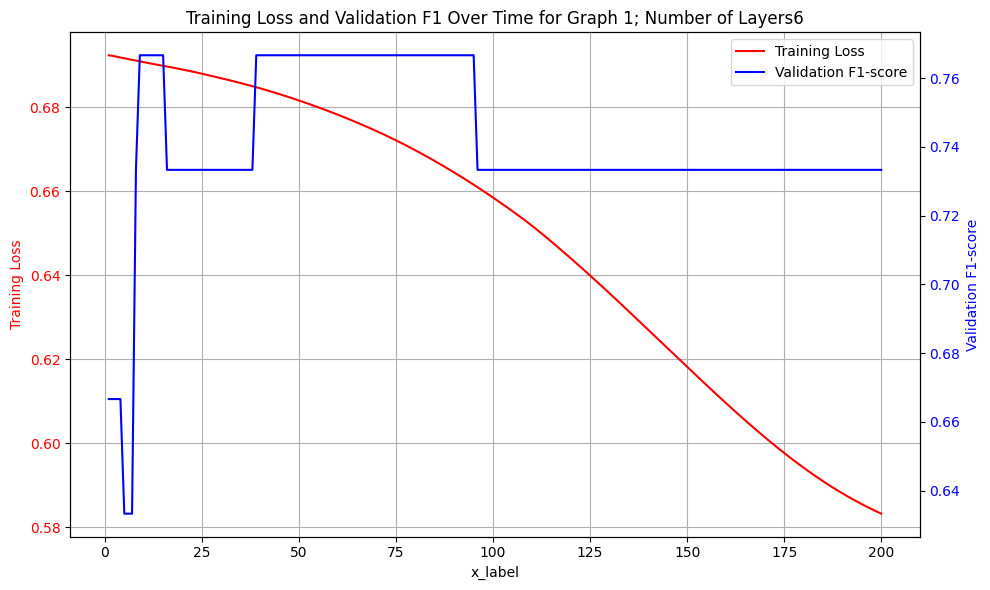

<Figure size 1000x600 with 0 Axes>

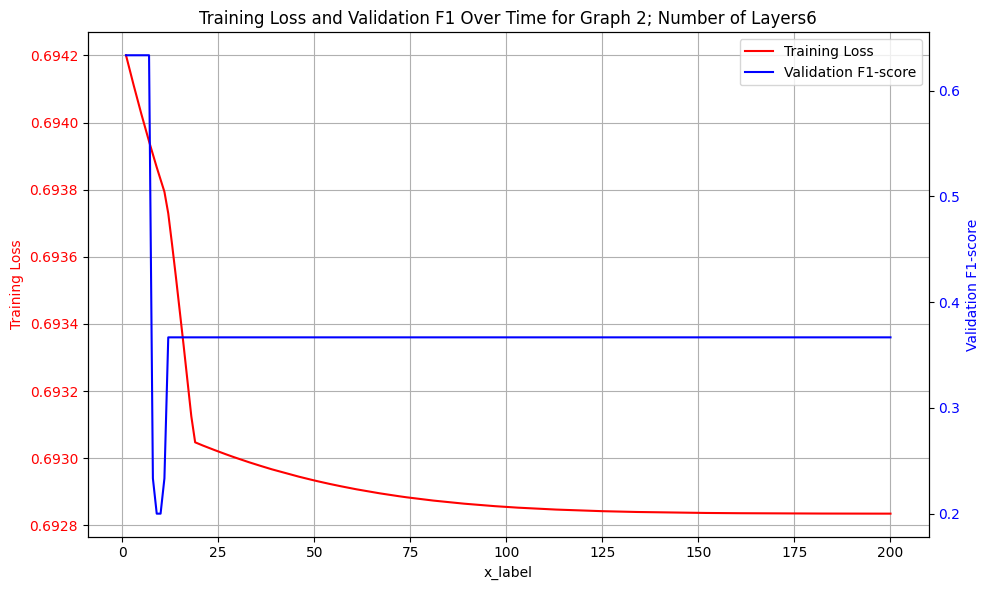

In [21]:
SEED = 42

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
set_seed(SEED)

# Load data
G1_train = read_json_data(G1_TRAIN_DATA_PATH, has_label=True) #returns a list of (X,A,y) - features, Adj Matrix, per Graph label
G1_eval = read_json_data(G1_EVAL_DATA_PATH, has_label=True) #returns a list of (X,A,y) - features, Adj Matrix, per Graph label

G2_train = read_json_data(G2_TRAIN_DATA_PATH, has_label=True) #returns a list of (X,A,y) - features, Adj Matrix, per Graph label
G2_eval = read_json_data(G2_EVAL_DATA_PATH, has_label=True) #returns a list of (X,A,y) - features, Adj Matrix, per Graph label


# Patch A
G1_train = (G1_train[0], patch_A_matrix(G1_train[1]), G1_train[2])
G1_eval = (G1_eval[0], patch_A_matrix(G1_eval[1]), G1_eval[2])

G2_train = (G2_train[0], patch_A_matrix(G2_train[1]), G2_train[2])
G2_eval = (G2_eval[0], patch_A_matrix(G2_eval[1]), G2_eval[2])

# Initialising the model
input_dim = 10
hidden_dim = 8
for num_layers in [2, 3, 4, 5, 6]:
    model = LayeredGCN(input_dim, hidden_dim, num_layers=num_layers)

    losses, train_f1, val_f1 = train_model(
        model,
        G1_train,
        G1_eval,
        num_epochs=200,
        lr=0.0005,
        verbose=False,
    )
    plot_training_and_validation(losses, val_f1, graph1_label="Training Loss", graph2_label="Validation F1-score", title=f"Training Loss and Validation F1 Over Time for Graph 1; Number of Layers{num_layers}", x_label="Epoch")


    model = LayeredGCN(input_dim, hidden_dim, num_layers=num_layers)

    losses, train_f2, val_f2 = train_model(
        model,
        G2_train,
        G2_eval,
        num_epochs=200,
        lr=0.0005,
        verbose=False,
    )
    plot_training_and_validation(losses, val_f2, graph1_label="Training Loss", graph2_label="Validation F1-score", title=f"Training Loss and Validation F1 Over Time for Graph 2; Number of Layers{num_layers}", x_label="Epoch")





### Q3.2.b - Plotting of t-SNE Embeddings for Graph Neural Networks

• Use t-SNE to visualize the node embeddings for the final layer of the GCN for each graph
for both training and evaluation data, use the labels as class labels for the tsne plot.

In [22]:
# SOLUTION Q3.5.b
# ####################################################
# MODIFY THE CODE BELOW 
# ####################################################  

def plot_tsne(embeddings, labels=None, layer_to_plot=-1, subject="Node Embeddings"):
    """
    embeddings (list):
        list of embeddings (layer 2, ..., layer N)
        NOTE: for num_layer = 1 there is no embedding (as it is just the input)
    
    labels (list):
        list of labels
    
    layer_to_plot (int):
        which layer to plot (default -1, i.e. the last layer)
    """
    if not embeddings:
        raise ValueError("Embeddings list is empty.")
    
    # Select the embedding for the chosen layer
    chosen_embedding = embeddings[layer_to_plot]
    
    if isinstance(chosen_embedding, torch.Tensor):
        chosen_embedding = chosen_embedding.detach().cpu().numpy()
    
    # Adjust perplexity dynamically
    perplexity = min(30, len(chosen_embedding) - 1)
    
    # Perform t-SNE dimensionality reduction
    tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity)
    reduced_embeddings = tsne.fit_transform(chosen_embedding)
    
    # Plot the embeddings
    plt.figure(figsize=(8, 6))
    
    if labels is not None:
        labels = np.array(labels)
        scatter = plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=labels, cmap='jet', alpha=0.7)
        plt.colorbar(scatter, label="Labels")
    else:
        plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], alpha=0.7)
    
    plt.title(f"t-SNE Visualization of {subject} (Layer {layer_to_plot})")
    plt.xlabel("t-SNE Dim 1")
    plt.ylabel("t-SNE Dim 2")
    plt.show()

# ####################################################
# END OF MODIFICATION
# ####################################################  

### Plotting the t-SNE embeddings

Adapt as needed.

Epoch 1, Training Loss: 6.331419467926025, Train F1: 0.4625, Validation F1: 0.5000
Epoch 2, Training Loss: 6.273720741271973, Train F1: 0.4625, Validation F1: 0.5000
Epoch 3, Training Loss: 6.216290473937988, Train F1: 0.4625, Validation F1: 0.5000
Epoch 4, Training Loss: 6.159153938293457, Train F1: 0.4625, Validation F1: 0.5000
Epoch 5, Training Loss: 6.1024065017700195, Train F1: 0.4625, Validation F1: 0.5000
Epoch 6, Training Loss: 6.045904636383057, Train F1: 0.4625, Validation F1: 0.5000
Epoch 7, Training Loss: 5.989638328552246, Train F1: 0.4625, Validation F1: 0.5000
Epoch 8, Training Loss: 5.933669567108154, Train F1: 0.4625, Validation F1: 0.5000
Epoch 9, Training Loss: 5.878208637237549, Train F1: 0.4625, Validation F1: 0.5000
Epoch 10, Training Loss: 5.823331356048584, Train F1: 0.4625, Validation F1: 0.5000
Epoch 11, Training Loss: 5.7688493728637695, Train F1: 0.4625, Validation F1: 0.5000
Epoch 12, Training Loss: 5.714608669281006, Train F1: 0.4625, Validation F1: 0.5000

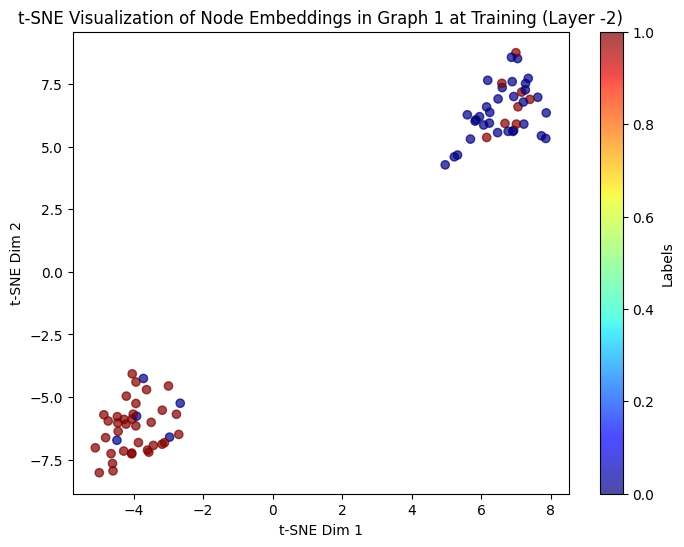

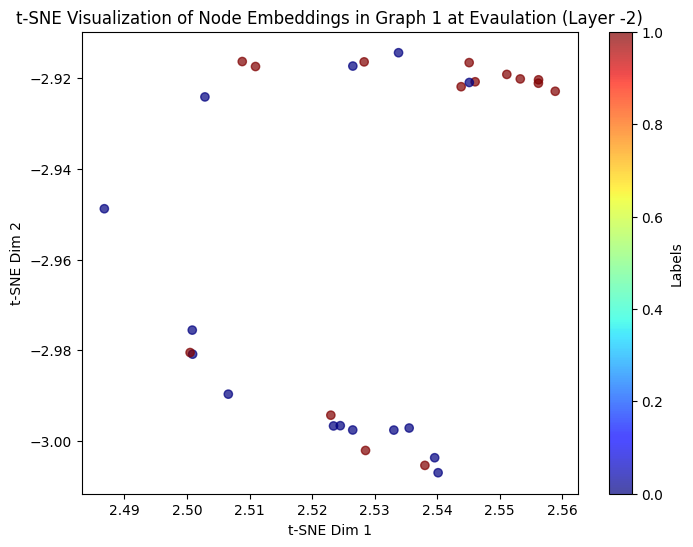

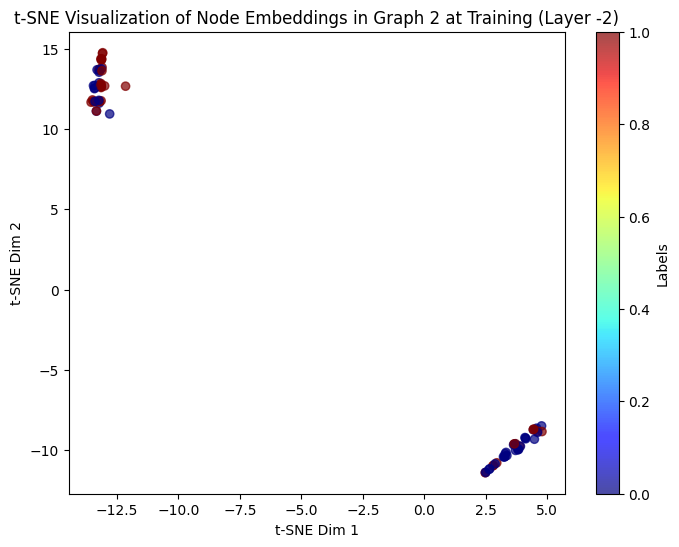

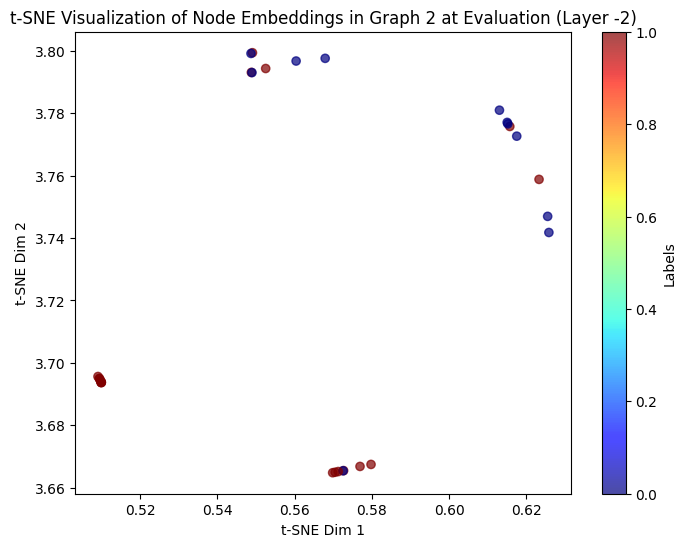

In [23]:
set_seed(42)

# Load data
G1_train = read_json_data(G1_TRAIN_DATA_PATH, has_label=True) #returns a list of (X,A,y) - features, Adj Matrix, per Graph label
G1_eval = read_json_data(G1_EVAL_DATA_PATH, has_label=True) #returns a list of (X,A,y) - features, Adj Matrix, per Graph label

G2_train = read_json_data(G2_TRAIN_DATA_PATH, has_label=True) #returns a list of (X,A,y) - features, Adj Matrix, per Graph label
G2_eval = read_json_data(G2_EVAL_DATA_PATH, has_label=True) #returns a list of (X,A,y) - features, Adj Matrix, per Graph label

# Initialising the model
input_dim = 10
hidden_dim = 8
num_layers = 3
model = LayeredGCN(input_dim, hidden_dim, num_layers=num_layers)

losses, _, val_f1, last_embeddings_g1_train = train_model(
    model,
    G1_train,
    G1_eval,
    num_epochs=200,
    lr=0.0005,
    verbose=True,
    return_embeddings = True #NOTE we added this parameter
)

with torch.no_grad():
    _, last_embeddings_g1_eval = model(A=G1_eval[1], X=G1_eval[0], return_embeddings=True)

# plot_training_and_validation(losses, val_f1)

model = LayeredGCN(input_dim, hidden_dim, num_layers=num_layers)

_, _, _, last_embeddings_g2_train = train_model(model, G2_train, G2_eval, num_epochs=200, lr=0.0005, verbose=False, return_embeddings=True)

with torch.no_grad():
    _, last_embeddings_g2_eval = model(A=G2_eval[1], X=G2_eval[0], return_embeddings=True)



_,_,y_g1_train = G1_train
_,_,y_g1_eval = G1_eval
_,_,y_g2_train = G2_train
_,_,y_g2_eval = G2_eval

plot_tsne(last_embeddings_g1_train, y_g1_train, layer_to_plot=-2, subject="Node Embeddings in Graph 1 at Training")
plot_tsne(last_embeddings_g1_eval, y_g1_eval, layer_to_plot=-2, subject="Node Embeddings in Graph 1 at Evaulation")
plot_tsne(last_embeddings_g2_train, y_g2_train, layer_to_plot=-2, subject="Node Embeddings in Graph 2 at Training")
plot_tsne(last_embeddings_g2_eval, y_g2_eval, layer_to_plot=-2, subject="Node Embeddings in Graph 2 at Evaluation")

### Q3.2.c - Training the Model on Merged Graphs G = G1 ∪ G

• Implement a GCN that trains on both graphs at once. Plot the training curve.

• Compare the performance of G = G1 ∪ G2 against training on G1 and G2, respectively.

• Plot TSNE plots.

In [24]:
# SOLUTION Q3.2.c
# ####################################################
# MODIFY THE CODE BELOW 
# ####################################################  

# Implement the training of G = {G1 U G2}
def combine_graphs(G1, G2):
    X1, A1, y1 = G1
    X2, A2, y2 = G2

    X_combined = torch.cat([X1, X2], dim=0)

    # Combine the adjacency matrices
    size1, size2 = A1.shape[0], A2.shape[0]
    new_size = size1 + size2  # Assuming nodes are indexed 0,1,2,...

    # Expand matrices to the new unified size
    expanded_A = torch.zeros((new_size, new_size))

    expanded_A[:size1, :size1] = A1
    expanded_A[size1:, size1:] = A2

    y_combined = torch.cat([y1, y2], dim=0)

    return X_combined, expanded_A, y_combined

# In the end return a single function:
def train_G1UG2(G1_train, G1_eval, G2_train, G2_eval, num_epochs=200, lr=0.001, verbose=True, return_embeddings=False):
    """"""
    G_train_combined = combine_graphs(G1_train, G2_train)
    G_eval_combined = combine_graphs(G1_eval, G2_eval)

    input_dim = G_train_combined[0].shape[1]
    hidden_dim = 8
    num_layers = 3

    model = LayeredGCN(input_dim, hidden_dim, num_layers=num_layers)
    results = train_model(
        model,
        G_train_combined,
        G_eval_combined,
        num_epochs=num_epochs,
        lr=lr,
        verbose=verbose,
        return_embeddings = return_embeddings
    )

    return results



# ####################################################
# END OF MODIFICATION
# ####################################################  

### Running the evaluation.

Epoch 1, Training Loss: 27.54071044921875, Train F1: 0.4875, Validation F1: 0.4333
Epoch 2, Training Loss: 27.483142852783203, Train F1: 0.4875, Validation F1: 0.4333
Epoch 3, Training Loss: 27.42618751525879, Train F1: 0.4875, Validation F1: 0.4333
Epoch 4, Training Loss: 27.369770050048828, Train F1: 0.4875, Validation F1: 0.4333
Epoch 5, Training Loss: 27.314001083374023, Train F1: 0.4875, Validation F1: 0.4333
Epoch 6, Training Loss: 27.259225845336914, Train F1: 0.4875, Validation F1: 0.4333
Epoch 7, Training Loss: 27.2049560546875, Train F1: 0.4875, Validation F1: 0.4333
Epoch 8, Training Loss: 27.15115737915039, Train F1: 0.4875, Validation F1: 0.4333
Epoch 9, Training Loss: 27.097991943359375, Train F1: 0.4875, Validation F1: 0.4333
Epoch 10, Training Loss: 27.04574966430664, Train F1: 0.4875, Validation F1: 0.4333
Epoch 11, Training Loss: 26.9940242767334, Train F1: 0.4875, Validation F1: 0.4333
Epoch 12, Training Loss: 26.943042755126953, Train F1: 0.4875, Validation F1: 0.43

<Figure size 1000x600 with 0 Axes>

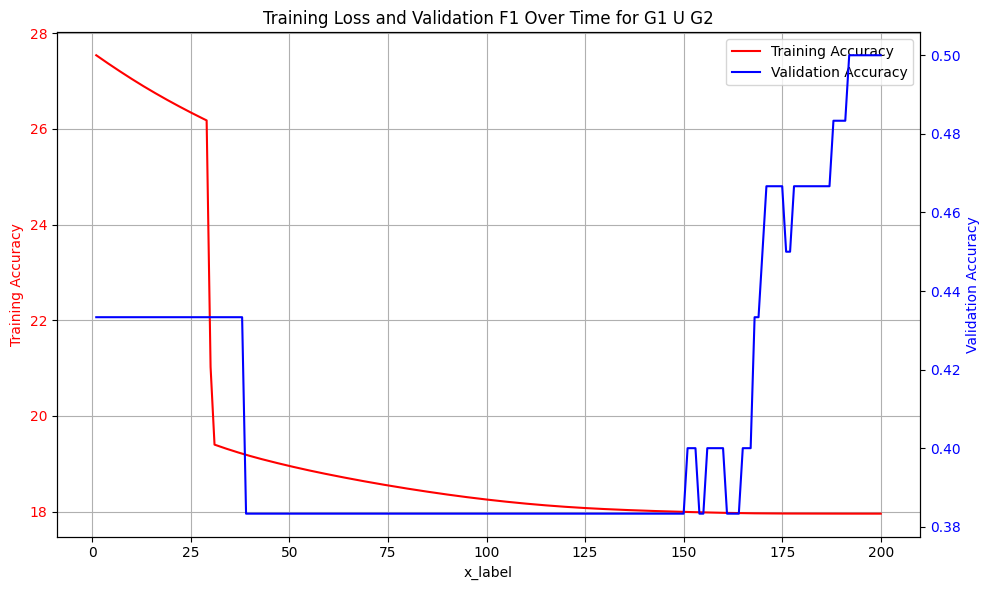

In [25]:

# Load data
set_seed(42)
G1_train = read_json_data(G1_TRAIN_DATA_PATH, has_label=True) #returns a list of (X,A,y) - features, Adj Matrix, per Graph label
G1_eval = read_json_data(G1_EVAL_DATA_PATH, has_label=True) #returns a list of (X,A,y) - features, Adj Matrix, per Graph label

G2_train = read_json_data(G2_TRAIN_DATA_PATH, has_label=True) #returns a list of (X,A,y) - features, Adj Matrix, per Graph label
G2_eval = read_json_data(G2_EVAL_DATA_PATH, has_label=True) #returns a list of (X,A,y) - features, Adj Matrix, per Graph label

losses, train_f1, val_f1 = train_G1UG2(G1_train, G1_eval, G2_train, G2_eval, num_epochs=200, lr=0.001, verbose=True)

plot_training_and_validation(losses, val_f1, title="Training Loss and Validation F1 Over Time for G1 U G2", x_label="Epoch")


In [ ]:
# Comparing Performance
set_seed(42)
G1_train = read_json_data(G1_TRAIN_DATA_PATH, has_label=True) #returns a list of (X,A,y) - features, Adj Matrix, per Graph label
G1_eval = read_json_data(G1_EVAL_DATA_PATH, has_label=True) #returns a list of (X,A,y) - features, Adj Matrix, per Graph label

G2_train = read_json_data(G2_TRAIN_DATA_PATH, has_label=True) #returns a list of (X,A,y) - features, Adj Matrix, per Graph label
G2_eval = read_json_data(G2_EVAL_DATA_PATH, has_label=True) #returns a list of (X,A,y) - features, Adj Matrix, per Graph label

G1UG2_results=[]
G1_results_final=[]
G2_results_final=[]

num_layers = 3

for i in range(10):

    losses, train_f1, val_f1 = train_G1UG2(G1_train, G1_eval, G2_train, G2_eval, num_epochs=200, lr=0.001, verbose=False)
    
    print(f"Iteration {i}: G1UG2 Results: f1={val_f1[-1]}")
    G1UG2_results.append([losses, train_f1, val_f1])

    model = LayeredGCN(input_dim, hidden_dim, num_layers=num_layers)

    losses, train_f1, val_f1 = train_model(
        model,
        G1_train,
        G1_eval,
        num_epochs=200,
        lr=0.0005,
        verbose=False,
    )

    print(f"Iteration {i}: G1 Results: f1={val_f1[-1]}")
    G1_results_final.append([losses, train_f1, val_f1])

    model = LayeredGCN(input_dim, hidden_dim, num_layers=num_layers)

    losses, train_f2, val_f2 = train_model(
        model,
        G2_train,
        G2_eval,
        num_epochs=200,
        lr=0.0005,
        verbose=False,
    )

    print(f"Iteration {i}: G2 Results: f1={val_f1[-1]}")
    G2_results_final.append([losses, train_f1, val_f1])  

    

Iteration 0: G1UG2 Results: f1=0.5
Iteration 0: G1 Results: f1=0.7666666666666667
Iteration 0: G2 Results: f1=0.7666666666666667
Iteration 1: G1UG2 Results: f1=0.6666666666666666
Iteration 1: G1 Results: f1=0.7
Iteration 1: G2 Results: f1=0.7
Iteration 2: G1UG2 Results: f1=0.4666666666666667
Iteration 2: G1 Results: f1=0.7333333333333333
Iteration 2: G2 Results: f1=0.7333333333333333
Iteration 3: G1UG2 Results: f1=0.5666666666666667
Iteration 3: G1 Results: f1=0.7333333333333333
Iteration 3: G2 Results: f1=0.7333333333333333
Iteration 4: G1UG2 Results: f1=0.7666666666666667
Iteration 4: G1 Results: f1=0.7333333333333333
Iteration 4: G2 Results: f1=0.7333333333333333
Iteration 5: G1UG2 Results: f1=0.6
Iteration 5: G1 Results: f1=0.7666666666666667
Iteration 5: G2 Results: f1=0.7666666666666667
Iteration 6: G1UG2 Results: f1=0.6833333333333333
Iteration 6: G1 Results: f1=0.5
Iteration 6: G2 Results: f1=0.5
Iteration 7: G1UG2 Results: f1=0.4666666666666667
Iteration 7: G1 Results: f1=0.73

<Figure size 1000x600 with 0 Axes>

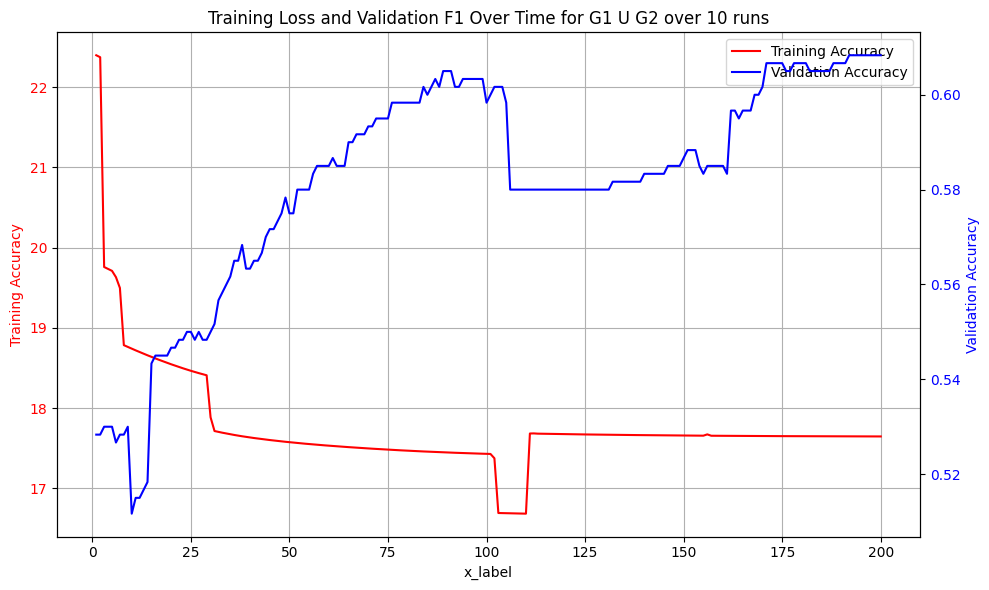

<Figure size 1000x600 with 0 Axes>

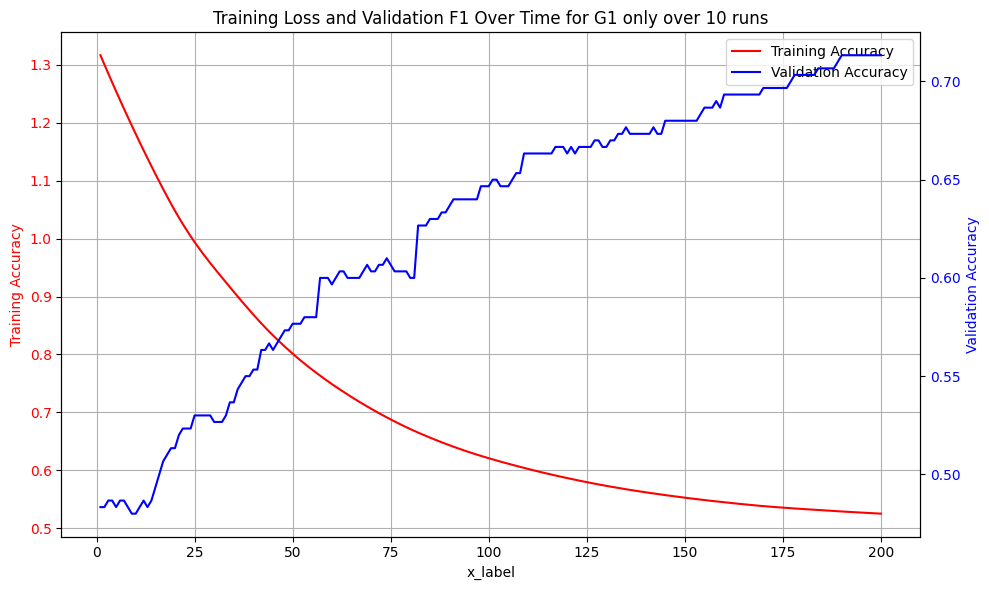

<Figure size 1000x600 with 0 Axes>

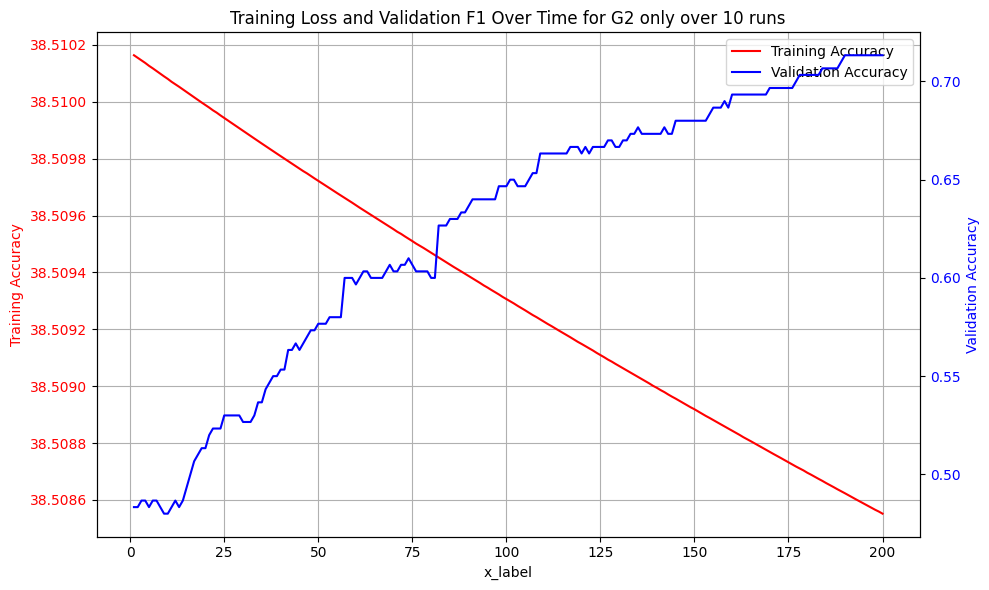

In [ ]:
# Get the mean of their train loss and val_f1
mean_G1UG2_results = np.mean(G1UG2_results, axis=0)
mean_G1_results = np.mean(G1_results_final, axis=0)
mean_G2_results = np.mean(G2_results_final, axis=0)

mean_G1UG2_losses = mean_G1UG2_results[0]
mean_G1UG2_val_f1 = mean_G1UG2_results[2]

mean_G1_losses = mean_G1_results[0]
mean_G1_val_f1 = mean_G1_results[2]

mean_G2_losses = mean_G2_results[0]
mean_G2_val_f1 = mean_G2_results[2]

plot_training_and_validation(mean_G1UG2_losses, mean_G1UG2_val_f1, title="Training Loss and Validation F1 Over Time for G1 U G2 over 10 runs", x_label="Epoch")
plot_training_and_validation(mean_G1_losses, mean_G1_val_f1, title="Training Loss and Validation F1 Over Time for G1 only over 10 runs", x_label="Epoch")
plot_training_and_validation(mean_G2_losses, mean_G2_val_f1, title="Training Loss and Validation F1 Over Time for G2 only over 10 runs", x_label="Epoch")

### Q3.2.d Implement & discuss what you observe.

• Compare training results, embeddings, and overall observations between independent and
merged training.

• Formulate a hypothesis explaining your observations.

• Discuss different implementation options for training on both graphs, including your choice.
(e.g. what model modifications are possible; what training modifications are possible?)

• Provide relevant plots and tables where appropriate.

• Bonus: Implement a modification (or alternative approach) for training on G1 ∪ G2 and
compare outcomes.

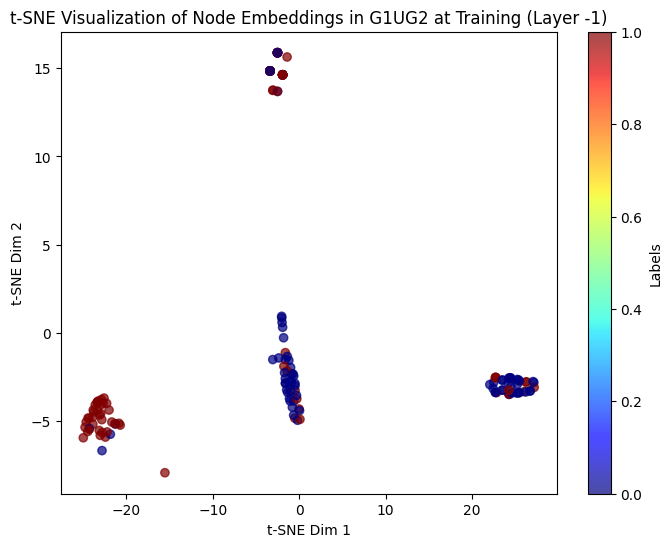

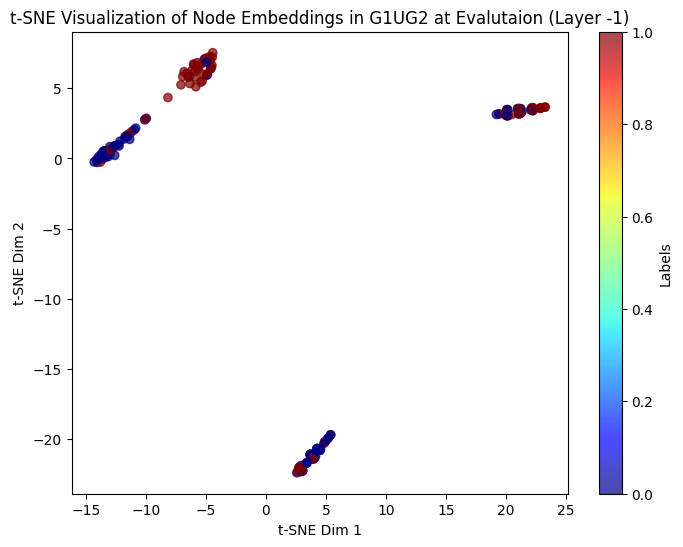

In [28]:
# SOLUTION Q3.2.d
# ####################################################
# MODIFY THE CODE BELOW 
# ####################################################  

# Implement the training of G = {G1 U G2}

# In the end return a single function:
# def train_G1UG2_v2(G1_train, G1_eval, G2_train, G2_eval, num_epochs=200, lr=0.001, verbose=True):
#     """"""
#     # INSERT necessary things
    
#     return losses, train_f1, val_f1

set_seed(40)

_,_,y_g1_train = G1_train
_,_,y_g1_eval = G1_eval
_,_,y_g2_train = G2_train
_,_,y_g2_eval = G2_eval

y_combined_train = torch.cat([y_g1_train, y_g2_train], dim=0)

_, _, _, last_embeddings_combined_train = train_G1UG2(G1_train, G1_eval, G2_train, G2_eval, num_epochs=200, lr=0.001, verbose=False, return_embeddings=True)

plot_tsne(last_embeddings_combined_train, y_combined_train, layer_to_plot=-1, subject="Node Embeddings in G1UG2 at Training")

    
X_combined, expanded_A, y_combined_eval = combine_graphs(G1_train, G2_train)

with torch.no_grad():
    _, last_embeddings_combined_eval = model(A=expanded_A, X=X_combined, return_embeddings=True)

plot_tsne(last_embeddings_combined_eval, y_combined_eval, layer_to_plot=-1, subject="Node Embeddings in G1UG2 at Evalutaion")

# ####################################################
# END OF MODIFICATION
# ####################################################  

### Runnning the evaluation. 

Note: It is optional to run this particular evaluation. You can modify it as needed.

Epoch 1, Training Loss: 9.494964599609375, Train F1: 0.6062, Validation F1: 0.6167
Epoch 2, Training Loss: 9.468145370483398, Train F1: 0.6062, Validation F1: 0.6167
Epoch 3, Training Loss: 9.442100524902344, Train F1: 0.6062, Validation F1: 0.6167
Epoch 4, Training Loss: 9.416891098022461, Train F1: 0.6062, Validation F1: 0.6167
Epoch 5, Training Loss: 9.3925199508667, Train F1: 0.6062, Validation F1: 0.6167
Epoch 6, Training Loss: 9.369119644165039, Train F1: 0.6062, Validation F1: 0.6167
Epoch 7, Training Loss: 9.347074508666992, Train F1: 0.6062, Validation F1: 0.6333
Epoch 8, Training Loss: 9.326177597045898, Train F1: 0.6125, Validation F1: 0.6167
Epoch 9, Training Loss: 9.306788444519043, Train F1: 0.6125, Validation F1: 0.6167
Epoch 10, Training Loss: 9.289131164550781, Train F1: 0.6312, Validation F1: 0.6167
Epoch 11, Training Loss: 9.273874282836914, Train F1: 0.6312, Validation F1: 0.6167
Epoch 12, Training Loss: 9.260430335998535, Train F1: 0.6375, Validation F1: 0.6167
Epo

<Figure size 1000x600 with 0 Axes>

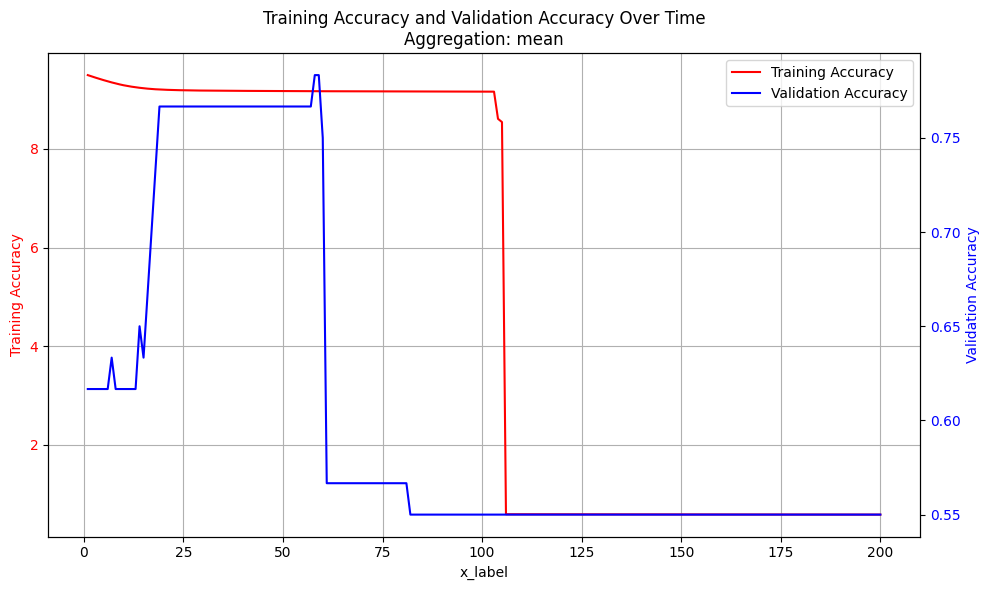

In [29]:

# Load data
set_seed(10)
G1_train = read_json_data(G1_TRAIN_DATA_PATH, has_label=True) #returns a list of (X,A,y) - features, Adj Matrix, per Graph label
G1_eval = read_json_data(G1_EVAL_DATA_PATH, has_label=True) #returns a list of (X,A,y) - features, Adj Matrix, per Graph label

G2_train = read_json_data(G2_TRAIN_DATA_PATH, has_label=True) #returns a list of (X,A,y) - features, Adj Matrix, per Graph label
G2_eval = read_json_data(G2_EVAL_DATA_PATH, has_label=True) #returns a list of (X,A,y) - features, Adj Matrix, per Graph label

losses, train_f1, val_f1 = train_G1UG2(G1_train, G1_eval, G2_train, G2_eval, num_epochs=200, lr=0.001, verbose=True)

plot_training_and_validation(losses, val_f1)


## 3.3 Topological changes to improve training

### Q3.3.a - Plot the Ricci Curvature for each edge.

• Plot a barplot of the the Ricci curvature per edge, where the x-axis are the edges and y-axis
is the ricci curvature.

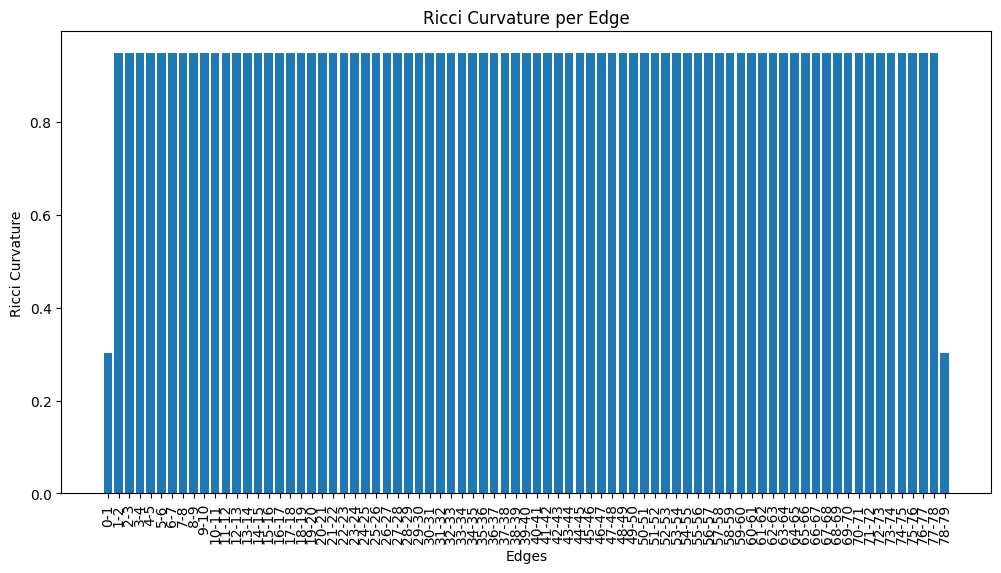

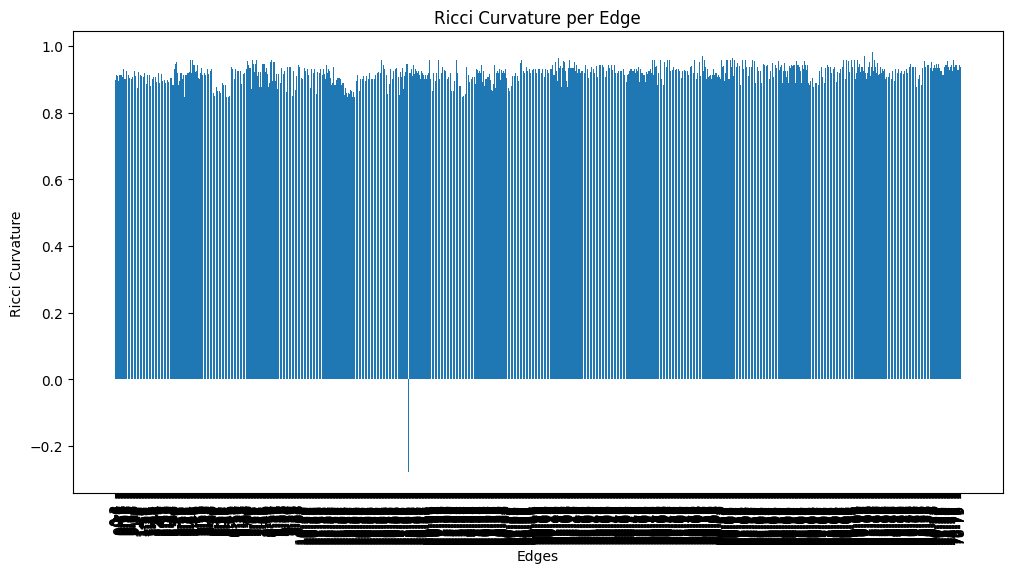

In [30]:
# SOLUTION Q3.3.a
# ####################################################
# MODIFY THE CODE BELOW 
# ####################################################  


# Load data
G1_train = read_json_data(G1_TRAIN_DATA_PATH, has_label=True) #returns a list of (X,A,y) - features, Adj Matrix, per Graph label
G1_eval = read_json_data(G1_EVAL_DATA_PATH, has_label=True) #returns a list of (X,A,y) - features, Adj Matrix, per Graph label

G2_train = read_json_data(G2_TRAIN_DATA_PATH, has_label=True) #returns a list of (X,A,y) - features, Adj Matrix, per Graph label
G2_eval = read_json_data(G2_EVAL_DATA_PATH, has_label=True) #returns a list of (X,A,y) - features, Adj Matrix, per Graph label


# Plot curvature against edges
from graph_ricci_curvature import GraphRicciCurvature 

def plot_ricci_per_edge(A):
    """
    Plots the Ricci curvature for each edge in the graph defined by adjacency matrix A.
    """
    # Convert PyTorch adjacency matrix to NumPy array
    A_np = A.numpy()

    # Create a NetworkX graph from the adjacency matrix
    G = nx.from_numpy_array(A_np)

    # Instantiate OllivierRicci object for the graph
    ricci_calculator = GraphRicciCurvature(G)

    # Compute the Ricci curvature
    curvatures = ricci_calculator.compute_ricci_curvatures()

    # Gather edge-level Ricci curvature values
    edges = list(curvatures.keys())
    ricci_values = list(curvatures.values())

    # Plot the Ricci curvature per edge
    plt.figure(figsize=(12, 6))
    plt.bar(range(len(edges)), ricci_values, tick_label=[f"{u}-{v}" for u, v in edges])
    plt.xlabel('Edges')
    plt.ylabel('Ricci Curvature')
    plt.title('Ricci Curvature per Edge')
    plt.xticks(rotation=90)
    plt.show()

# Example usage with G1_train adjacency matrix
plot_ricci_per_edge(G1_train[1])
plot_ricci_per_edge(G2_train[1])


# ####################################################
# END OF MODIFICATION
# ####################################################   

### Q3.3.b Investigate the extreme case topologies.

• How would you modify a topology so that the graph structure is ignored, making the GNN
behave like an MLP?

• What would an ideal graph structure be for optimal training and testing if labels were
available (both during training and testing)?

• What are you observations? Analyze the scores and what does it mean about the dataset?

• Provide relevant plots and results.

In [53]:
# SOLUTION Q3.3.b
# ####################################################
# MODIFY THE CODE BELOW 
# ####################################################  

def augment_graph_gold_labels(G):
    """Augment graph to return A that would be 'perfect'"""
    X,A,y = G

    # Set all connections with the same label to 1 others to 0
    for i in range(len(y)):
        for j in range(len(y)):
            if y[i] == y[j]:
                A[i, j] = 1
            else:
                A[i, j] = 0

    return X,A,y

def augment_graph_no_effect(G):
    """Modify graph to return A that has no 'effect'"""
    X,A,y = G

    # Set A to an indentity matrix
    A = torch.eye(A.size(0))

    return X, A, y

    
def improved_training(
        G_train,
        G_eval,
        model_params,
        num_epochs=200,
        lr=0.0005,
        verbose=True,
        return_embeddings = True,
        change_topology_params = {},
    ):
    """
    How can you improve the topologies to train better.
    """
    if change_topology_params["augmentation_strategy"] == "no_effect":
        augmentation_function = augment_graph_no_effect
    elif change_topology_params["augmentation_strategy"] == "gold":
        augmentation_function = augment_graph_gold_labels
    else:
        raise NotImplementedError("This augmentation setting is not implemented.")

    G_train = augmentation_function(G_train)
    G_eval = augmentation_function(G_eval)

    if change_topology_params["normalise"]:
        G_train = G_train[0],symmetric_normalize(G_train[1]),G_train[2]
        G_eval = G_eval[0],symmetric_normalize(G_eval[1]),G_eval[2]

    # Initialising the model
    model = LayeredGCN(**model_params)
    print(model)

    losses, train_f1, val_f1, last_embeddings = train_model(
        model,
        G_train,
        G_eval,
        num_epochs=num_epochs,
        lr=lr,
        verbose=verbose,
        return_embeddings = True
    )
    return losses, train_f1, val_f1, last_embeddings

# ####################################################
# END OF MODIFICATION
# ####################################################  


### Code to run improvement
Note: run it a few times to see what performance can be reached on the eval dataset.

In [ ]:
# Load data

set_seed(3)
G1_train = read_json_data(G1_TRAIN_DATA_PATH, has_label=True) #returns a list of (X,A,y) - features, Adj Matrix, per Graph label
G1_eval = read_json_data(G1_EVAL_DATA_PATH, has_label=True) #returns a list of (X,A,y) - features, Adj Matrix, per Graph label

G2_train = read_json_data(G2_TRAIN_DATA_PATH, has_label=True) #returns a list of (X,A,y) - features, Adj Matrix, per Graph label
G2_eval = read_json_data(G2_EVAL_DATA_PATH, has_label=True) #returns a list of (X,A,y) - features, Adj Matrix, per Graph label

model_params = {    
    "input_dim":10, 
    "hidden_dim":8,
    "num_layers":3,
}

change_topology_params = {
    "augmentation_strategy":"no_effect",
    "normalise" : False,
}

G1_results_final=[]
G2_results_final=[]

for i in range(10):
    losses, train_f1, val_f1, last_embeddings_G1 = improved_training(
        G1_train,
        G1_eval,
        model_params=model_params,
        num_epochs=250,
        lr=0.0005,
        verbose=True,
        return_embeddings = True,
        change_topology_params = change_topology_params #change as needed
    )

    print(f"Iteration {i}: G2 Results: f1={val_f1[-1]}")
    G2_results_final.append([losses, train_f1, val_f1, last_embeddings_G1]) 

    losses, train_f1, val_f1, last_embeddings_G2 = improved_training(
        G2_train,
        G2_eval,
        model_params=model_params,
        num_epochs=250,
        lr=0.0005,
        verbose=True,
        return_embeddings = True,
        change_topology_params = change_topology_params #change as needed
    )

    print(f"Iteration {i}: G1 Results: f1={val_f1[-1]}")
    G1_results_final.append([losses, train_f1, val_f1, last_embeddings_G2]) 

LayeredGCN(
  (layers): ModuleList(
    (0-2): 3 x GCNLayer()
  )
  (output_layer): GCNLayer()
)
Epoch 1, Training Loss: 0.6856775879859924, Train F1: 0.5375, Validation F1: 0.5000
Epoch 2, Training Loss: 0.6855083107948303, Train F1: 0.5375, Validation F1: 0.5000
Epoch 3, Training Loss: 0.685338020324707, Train F1: 0.5375, Validation F1: 0.5000
Epoch 4, Training Loss: 0.6851665377616882, Train F1: 0.5375, Validation F1: 0.5000
Epoch 5, Training Loss: 0.684994101524353, Train F1: 0.5375, Validation F1: 0.5000
Epoch 6, Training Loss: 0.6848207712173462, Train F1: 0.5375, Validation F1: 0.5000
Epoch 7, Training Loss: 0.6846463084220886, Train F1: 0.5375, Validation F1: 0.5000
Epoch 8, Training Loss: 0.6844707727432251, Train F1: 0.5375, Validation F1: 0.5000
Epoch 9, Training Loss: 0.6842926740646362, Train F1: 0.5375, Validation F1: 0.5000
Epoch 10, Training Loss: 0.6841126680374146, Train F1: 0.5375, Validation F1: 0.5000
Epoch 11, Training Loss: 0.6839306950569153, Train F1: 0.5375, V

<Figure size 1000x600 with 0 Axes>

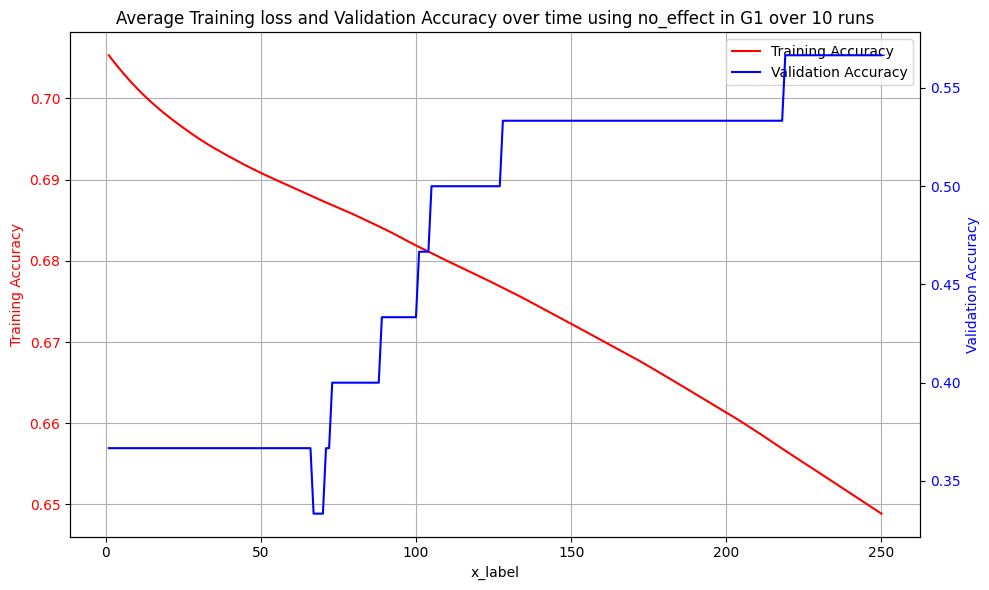

<Figure size 1000x600 with 0 Axes>

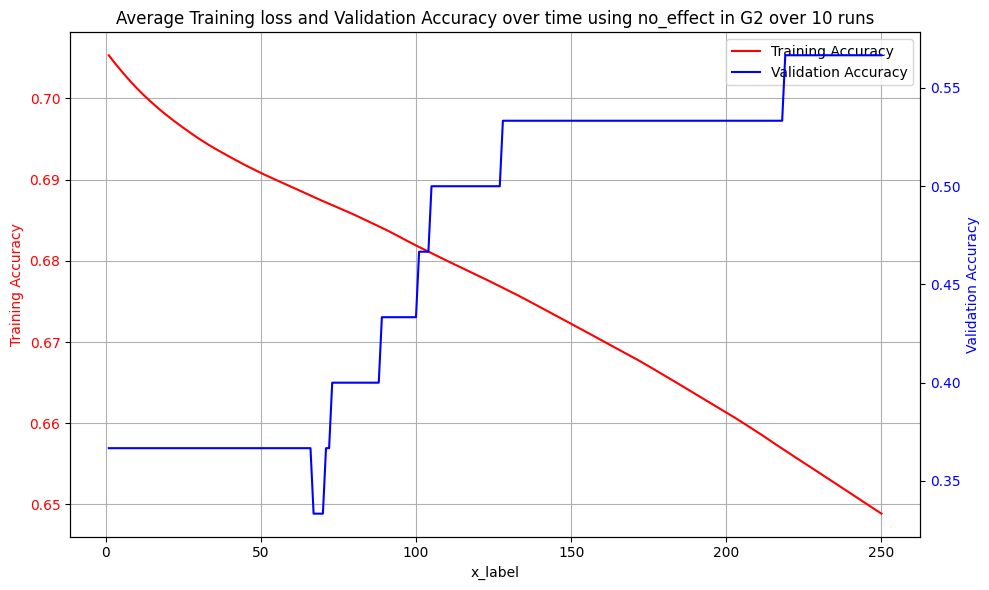

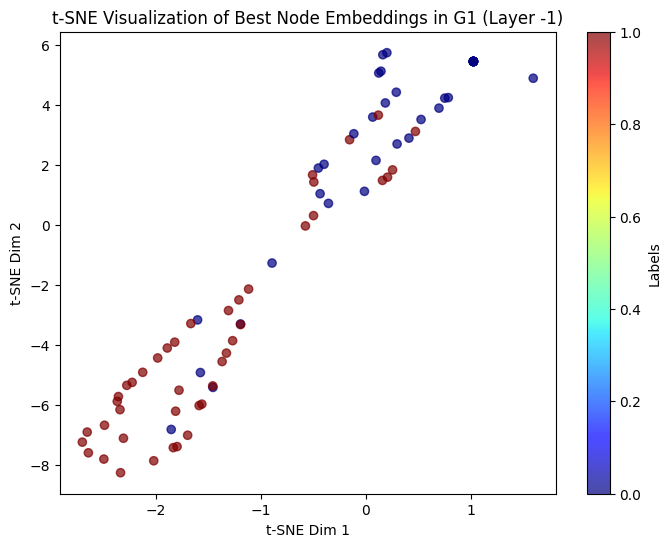

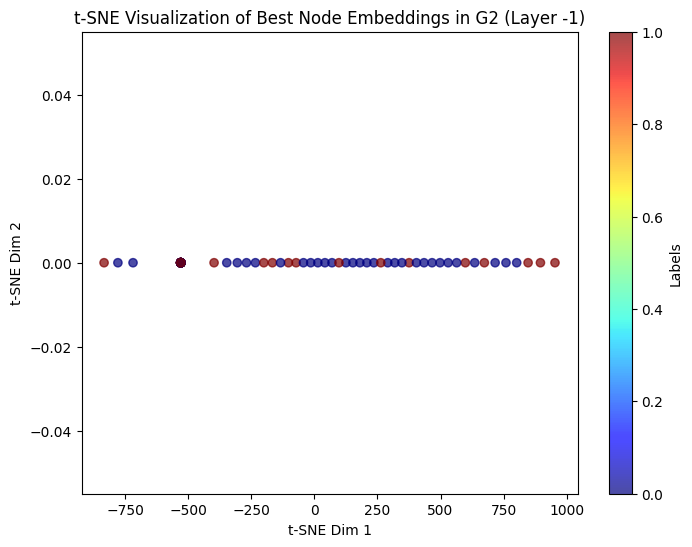

In [ ]:
best_epoch_G1 = max(range(len(G1_results_final)), key=lambda i: G1_results_final[i][2])
best_embedding_G1 = G1_results_final[best_epoch_G1][3]

best_epoch_G2 = max(range(len(G2_results_final)), key=lambda i: G2_results_final[i][2])
best_embedding_G2 = G2_results_final[best_epoch_G2][3]

G1_results_performance = [ result[:-1] for result in G1_results_final]
G2_results_performance = [ result[:-1] for result in G1_results_final]

mean_G1_results = np.mean(G1_results_performance, axis=0)
mean_G2_results = np.mean(G2_results_performance, axis=0)

mean_G1_losses = mean_G1_results[0]
mean_G1_val_f1 = mean_G1_results[2]

mean_G2_losses = mean_G2_results[0]
mean_G2_val_f1 = mean_G2_results[2]

plot_training_and_validation(mean_G1_losses, val_f1, title=f"Average Training loss and Validation Accuracy over time using {change_topology_params['augmentation_strategy']} in G1 over 10 runs")

plot_training_and_validation(mean_G2_losses, val_f1, title=f"Average Training loss and Validation Accuracy over time using {change_topology_params['augmentation_strategy']} in G2 over 10 runs")

X,A,y = G1_train
plot_tsne(best_embedding_G1, y, layer_to_plot=-1, subject="Best Node Embeddings in G1")

X,A,y = G2_train
plot_tsne(best_embedding_G2, y, layer_to_plot=-1, subject="Best Node Embeddings in G2")

In [ ]:
set_seed(42)
G1_train = read_json_data(G1_TRAIN_DATA_PATH, has_label=True) #returns a list of (X,A,y) - features, Adj Matrix, per Graph label
G1_eval = read_json_data(G1_EVAL_DATA_PATH, has_label=True) #returns a list of (X,A,y) - features, Adj Matrix, per Graph label

G2_train = read_json_data(G2_TRAIN_DATA_PATH, has_label=True) #returns a list of (X,A,y) - features, Adj Matrix, per Graph label
G2_eval = read_json_data(G2_EVAL_DATA_PATH, has_label=True) #returns a list of (X,A,y) - features, Adj Matrix, per Graph label

model_params = {    
    "input_dim":10, 
    "hidden_dim":8,
    "num_layers":3,
}

change_topology_params = {
    "augmentation_strategy":"gold",
    "normalise" : True,

}

G1_results_final=[]
G2_results_final=[]

for i in range(10):
    losses, train_f1, val_f1, last_embeddings_G1 = improved_training(
        G1_train,
        G1_eval,
        model_params=model_params,
        num_epochs=250,
        lr=0.0005,
        verbose=True,
        return_embeddings = True,
        change_topology_params = change_topology_params #change as needed
    )

    print(f"Iteration {i}: G2 Results: f1={val_f1[-1]}")
    G2_results_final.append([losses, train_f1, val_f1, last_embeddings_G1]) 

    losses, train_f1, val_f1, last_embeddings_G2 = improved_training(
        G2_train,
        G2_eval,
        model_params=model_params,
        num_epochs=250,
        lr=0.0005,
        verbose=True,
        return_embeddings = True,
        change_topology_params = change_topology_params #change as needed
    )

    print(f"Iteration {i}: G1 Results: f1={val_f1[-1]}")
    G1_results_final.append([losses, train_f1, val_f1, last_embeddings_G2]) 

LayeredGCN(
  (layers): ModuleList(
    (0-2): 3 x GCNLayer()
  )
  (output_layer): GCNLayer()
)
Epoch 1, Training Loss: 0.7758477330207825, Train F1: 0.4625, Validation F1: 0.5000
Epoch 2, Training Loss: 0.7731992602348328, Train F1: 0.4625, Validation F1: 0.5000
Epoch 3, Training Loss: 0.7705737948417664, Train F1: 0.4625, Validation F1: 0.5000
Epoch 4, Training Loss: 0.7679700255393982, Train F1: 0.4625, Validation F1: 0.5000
Epoch 5, Training Loss: 0.7654721140861511, Train F1: 0.4625, Validation F1: 0.5000
Epoch 6, Training Loss: 0.7631740570068359, Train F1: 0.4625, Validation F1: 0.5000
Epoch 7, Training Loss: 0.7608808875083923, Train F1: 0.4625, Validation F1: 0.5000
Epoch 8, Training Loss: 0.7585967779159546, Train F1: 0.4625, Validation F1: 0.5000
Epoch 9, Training Loss: 0.7563250660896301, Train F1: 0.4625, Validation F1: 0.5000
Epoch 10, Training Loss: 0.7540677189826965, Train F1: 0.4625, Validation F1: 0.5000
Epoch 11, Training Loss: 0.7518256306648254, Train F1: 0.4625,

<Figure size 1000x600 with 0 Axes>

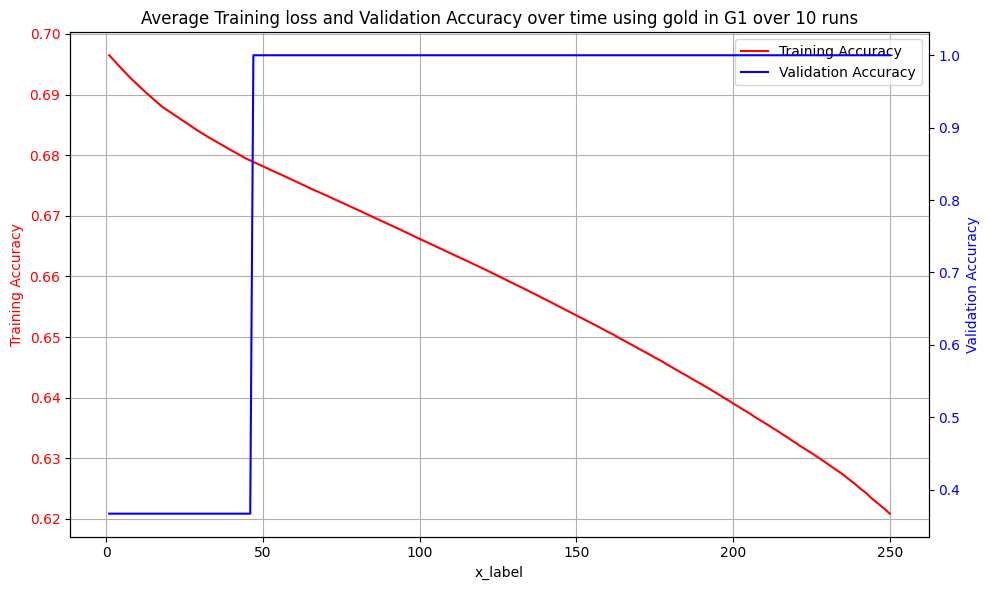

<Figure size 1000x600 with 0 Axes>

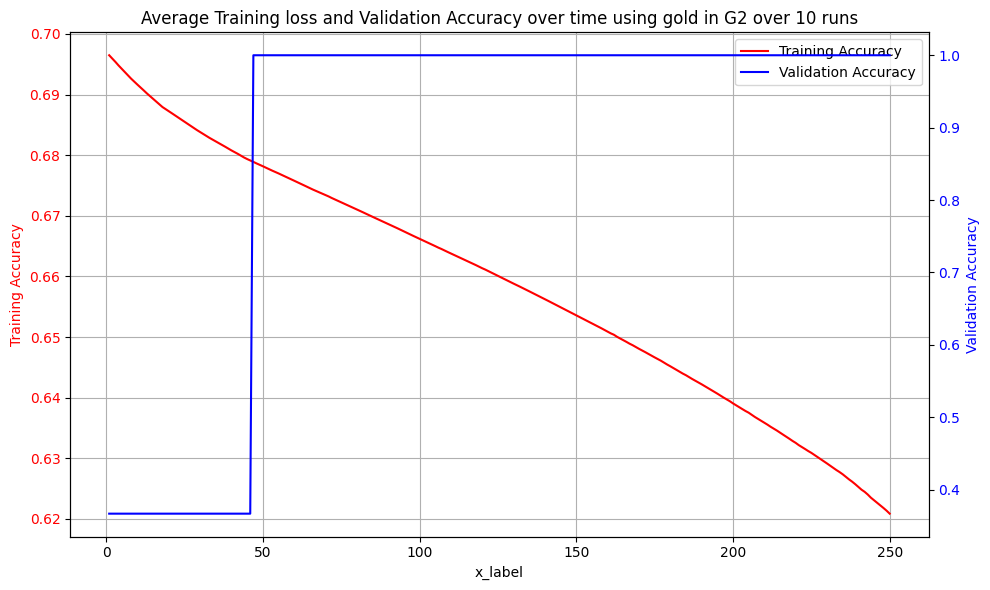

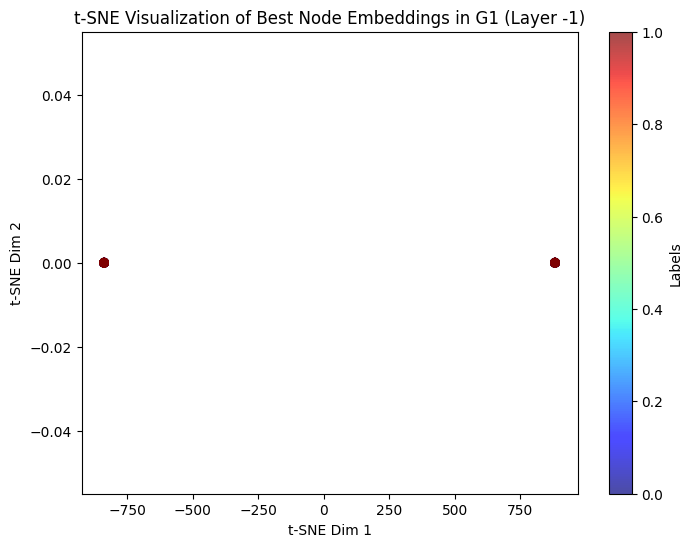

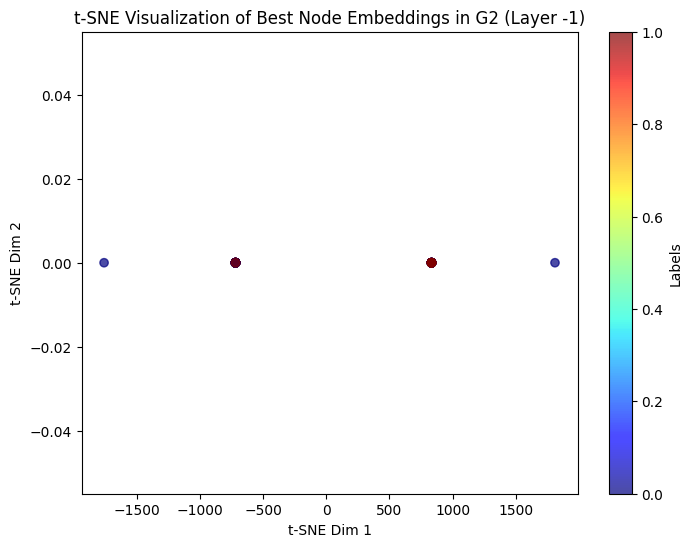

In [ ]:
best_epoch_G1 = max(range(len(G1_results_final)), key=lambda i: G1_results_final[i][2])
best_embedding_G1 = G1_results_final[best_epoch_G1][3]

best_epoch_G2 = max(range(len(G2_results_final)), key=lambda i: G2_results_final[i][2])
best_embedding_G2 = G2_results_final[best_epoch_G2][3]

G1_results_performance = [ result[:-1] for result in G1_results_final]
G2_results_performance = [ result[:-1] for result in G1_results_final]

mean_G1_results = np.mean(G1_results_performance, axis=0)
mean_G2_results = np.mean(G2_results_performance, axis=0)

mean_G1_losses = mean_G1_results[0]
mean_G1_val_f1 = mean_G1_results[2]

mean_G2_losses = mean_G2_results[0]
mean_G2_val_f1 = mean_G2_results[2]

plot_training_and_validation(mean_G1_losses, val_f1, title=f"Average Training loss and Validation Accuracy over time using {change_topology_params['augmentation_strategy']} in G1 over 10 runs")

plot_training_and_validation(mean_G2_losses, val_f1, title=f"Average Training loss and Validation Accuracy over time using {change_topology_params['augmentation_strategy']} in G2 over 10 runs")

X,A,y = G1_train
plot_tsne(best_embedding_G1, y, layer_to_plot=-1, subject="Best Node Embeddings in G1")

X,A,y = G2_train
plot_tsne(best_embedding_G2, y, layer_to_plot=-1, subject="Best Node Embeddings in G2")

### Q3.3.C Improving Graph Topology for Better Learning

• Implement two graph modifications.

• Describe your modifications.

• What motivated your implementation?

• If it helped give a hypothesis on why you think that is? If it did not give a hypothesis why
you think it did not help.

• Provide relevant plots and results

In [67]:
# SOLUTION Q3.3.c
# ####################################################
# MODIFY THE CODE BELOW 
# #################################################### 

from sklearn.metrics.pairwise import cosine_similarity 

def augment_graph_final(G):
    """Augments the graph."""
    X,A,y = G

    # Set all connections with the same label to 1 others to 0
    for i in range(len(y)):
        for j in range(len(y)):
            if y[i] == y[j]:
                A[i, j] *= 2
            else:
                A[i, j] *= 0.5


    similarity_matrix = cosine_similarity(X)

    # Apply similarity threshold
    similarity_threshold = 0.7
    similarity_matrix = (similarity_matrix >= similarity_threshold).astype(float)

    # Combine with original adjacency matrix using alpha
    alpha = 0.5
    augmented_A = alpha * A + (1 - alpha) * similarity_matrix

    # Normalize adjacency matrix (optional, for GNNs like GCN)
    row_sums = augmented_A.sum(axis=1, keepdims=True)
    augmented_A = augmented_A / np.maximum(row_sums, 1e-10)  # Avoid division by zero

    return X,augmented_A.float(),y
    
def improved_training_final(
        G_train,
        G_eval,
        model_params,
        num_epochs=200,
        lr=0.0005,
        verbose=True,
        return_embeddings = True,
        change_topology_params = {}
    ):
    """
    How can you improve the topologies to train better.
    """

    G_train = augment_graph_final(G_train)
    G_train = G_train[0],symmetric_normalize(G_train[1]),G_train[2]

    G_eval = augment_graph_final(G_eval)
    G_eval = G_eval[0],symmetric_normalize(G_eval[1]),G_eval[2]

    # Initialising the model
    model = LayeredGCN(**model_params)
    print(model)

    losses, train_f1, val_f1, last_embeddings = train_model(
        model,
        G_train,
        G_eval,
        num_epochs=num_epochs,
        lr=lr,
        verbose=verbose,
        return_embeddings = return_embeddings
    )
    return losses, train_f1, val_f1, last_embeddings

# ####################################################
# END OF MODIFICATION
# ####################################################  

### Code to run improvement

In [68]:
# Load data
G1_train = read_json_data(G1_TRAIN_DATA_PATH, has_label=True) #returns a list of (X,A,y) - features, Adj Matrix, per Graph label
G1_eval = read_json_data(G1_EVAL_DATA_PATH, has_label=True) #returns a list of (X,A,y) - features, Adj Matrix, per Graph label

G2_train = read_json_data(G2_TRAIN_DATA_PATH, has_label=True) #returns a list of (X,A,y) - features, Adj Matrix, per Graph label
G2_eval = read_json_data(G2_EVAL_DATA_PATH, has_label=True) #returns a list of (X,A,y) - features, Adj Matrix, per Graph label


model_params = {    
    "input_dim":10, 
    "hidden_dim":8,
    "num_layers":3,
}

change_topology_params = {
    "augmentation_strategy":"eval",
}

G1_results_final=[]
G2_results_final=[]

for i in range(10):
    losses, train_f1, val_f1, last_embeddings_G1 = improved_training_final(
        G1_train,
        G1_eval,
        model_params=model_params,
        num_epochs=250,
        lr=0.0005,
        verbose=True,
        return_embeddings = True,
        change_topology_params = change_topology_params #change as needed
    )

    print(f"Iteration {i}: G2 Results: f1={val_f1[-1]}")
    G2_results_final.append([losses, train_f1, val_f1, last_embeddings_G1]) 

    losses, train_f1, val_f1, last_embeddings_G2 = improved_training_final(
        G2_train,
        G2_eval,
        model_params=model_params,
        num_epochs=250,
        lr=0.0005,
        verbose=True,
        return_embeddings = True,
        change_topology_params = change_topology_params #change as needed
    )

    print(f"Iteration {i}: G1 Results: f1={val_f1[-1]}")
    G1_results_final.append([losses, train_f1, val_f1, last_embeddings_G2]) 

LayeredGCN(
  (layers): ModuleList(
    (0-2): 3 x GCNLayer()
  )
  (output_layer): GCNLayer()
)
Epoch 1, Training Loss: 0.6713289022445679, Train F1: 0.8500, Validation F1: 0.7667
Epoch 2, Training Loss: 0.6703853607177734, Train F1: 0.8500, Validation F1: 0.7667
Epoch 3, Training Loss: 0.6694458723068237, Train F1: 0.8500, Validation F1: 0.7667
Epoch 4, Training Loss: 0.6685103178024292, Train F1: 0.8500, Validation F1: 0.7667
Epoch 5, Training Loss: 0.66785728931427, Train F1: 0.8500, Validation F1: 0.7667
Epoch 6, Training Loss: 0.6674990653991699, Train F1: 0.8500, Validation F1: 0.7667
Epoch 7, Training Loss: 0.6671485900878906, Train F1: 0.8500, Validation F1: 0.7667
Epoch 8, Training Loss: 0.6668006181716919, Train F1: 0.8500, Validation F1: 0.7667
Epoch 9, Training Loss: 0.6664546728134155, Train F1: 0.8500, Validation F1: 0.7667
Epoch 10, Training Loss: 0.6661101579666138, Train F1: 0.8500, Validation F1: 0.7667
Epoch 11, Training Loss: 0.6657663583755493, Train F1: 0.8500, V

<Figure size 1000x600 with 0 Axes>

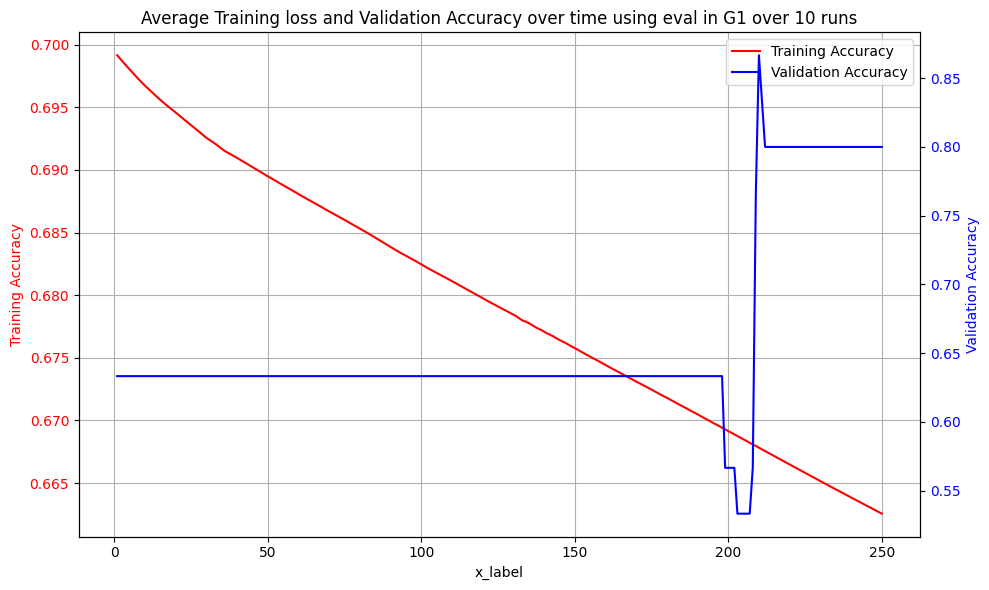

<Figure size 1000x600 with 0 Axes>

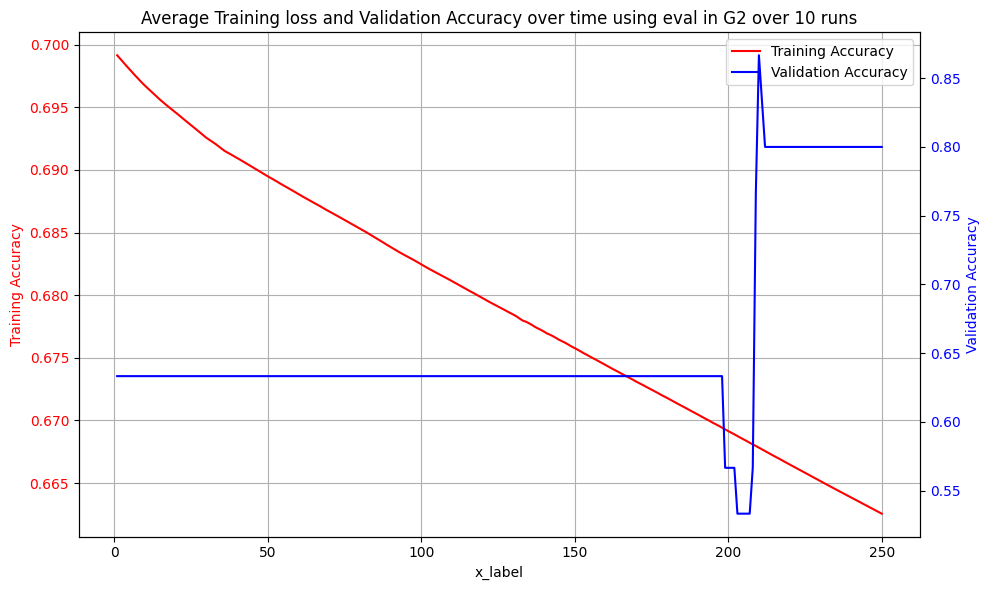

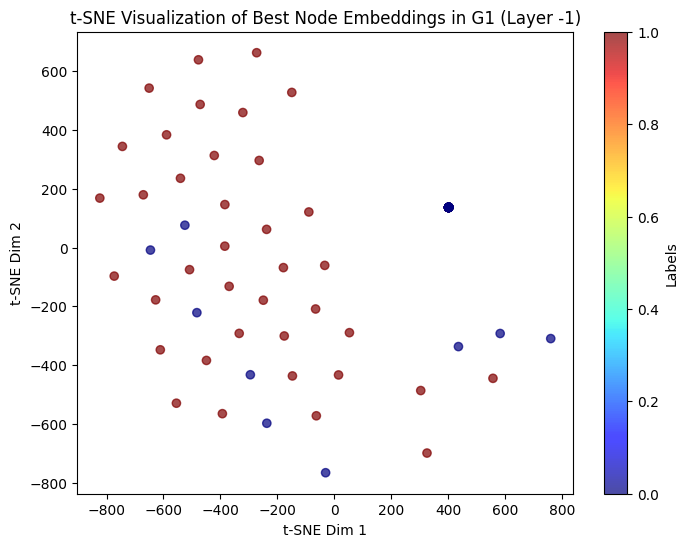

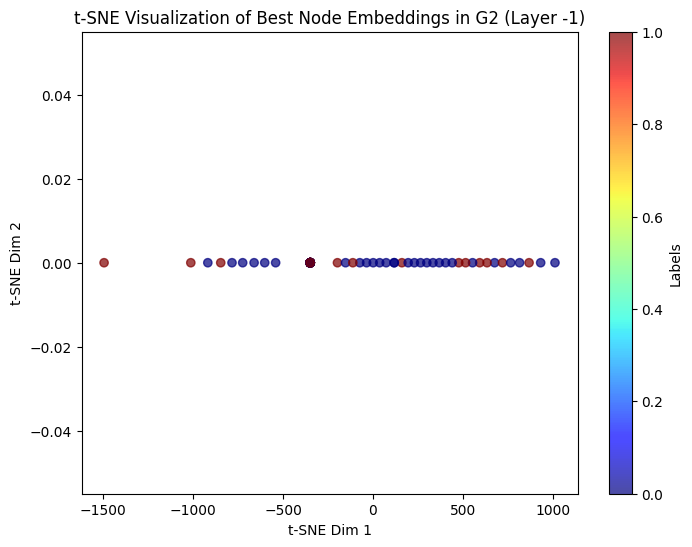

In [69]:
best_epoch_G1 = max(range(len(G1_results_final)), key=lambda i: G1_results_final[i][2])
best_embedding_G1 = G1_results_final[best_epoch_G1][3]

best_epoch_G2 = max(range(len(G2_results_final)), key=lambda i: G2_results_final[i][2])
best_embedding_G2 = G2_results_final[best_epoch_G2][3]

G1_results_performance = [ result[:-1] for result in G1_results_final]
G2_results_performance = [ result[:-1] for result in G1_results_final]

mean_G1_results = np.mean(G1_results_performance, axis=0)
mean_G2_results = np.mean(G2_results_performance, axis=0)

mean_G1_losses = mean_G1_results[0]
mean_G1_val_f1 = mean_G1_results[2]

mean_G2_losses = mean_G2_results[0]
mean_G2_val_f1 = mean_G2_results[2]

plot_training_and_validation(mean_G1_losses, val_f1, title=f"Average Training loss and Validation Accuracy over time using {change_topology_params['augmentation_strategy']} in G1 over 10 runs")

plot_training_and_validation(mean_G2_losses, val_f1, title=f"Average Training loss and Validation Accuracy over time using {change_topology_params['augmentation_strategy']} in G2 over 10 runs")

X,A,y = G1_train
plot_tsne(best_embedding_G1, y, layer_to_plot=-1, subject="Best Node Embeddings in G1")

X,A,y = G2_train
plot_tsne(best_embedding_G2, y, layer_to_plot=-1, subject="Best Node Embeddings in G2")